In [1499]:
##모듈 불러오기

import pandas as pd
import numpy as np
import datetime as dt
import sklearn

import seaborn as sns
# from pycaret.regression import*
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [1500]:
import os
os.getcwd()

'/Users/admin/PycharmProjects/pythonProject'

In [1501]:
#한글폰트 해결하기

from matplotlib import font_manager, rc

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [1502]:
#seaborn 한글폰트 해결하기
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [1503]:
## 데이터 로드 및 변환 및 feature 생성

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.info()
test.info()

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일

In [1504]:
# Feature extraction


# train
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수'] / train['본사정원수']
train['출장비율'] = train['본사출장자수'] / train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수'] / train['출근']
train['재택비율'] = train['현본사소속재택근무자수'] / train['본사정원수']
train['출장휴가재택비율'] = train['출장비율'] + train['휴가비율'] + train['재택비율']

# test
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수'] - (test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수'] / test['본사정원수']
test['출장비율'] = test['본사출장자수'] / test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수'] / test['출근']
test['재택비율'] = test['현본사소속재택근무자수'] / test['본사정원수']
test['출장휴가재택비율'] = test['출장비율'] + test['휴가비율'] + test['재택비율']


In [1505]:
# 요일 분포 보기
train['요일'].value_counts()

3    244
4    242
0    240
1    240
2    239
Name: 요일, dtype: int64

In [1506]:
test['요일'].value_counts()

2    11
3    10
4    10
1    10
0     9
Name: 요일, dtype: int64

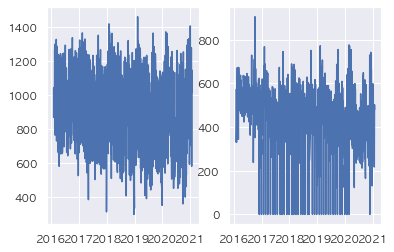

In [1507]:
# 식수인원 plot

plt.subplot(1,2,1)
plt.plot(train['일자'], train['중식계'])

plt.subplot(1,2,2)
plt.plot(train['일자'], train['석식계'])

plt.show()

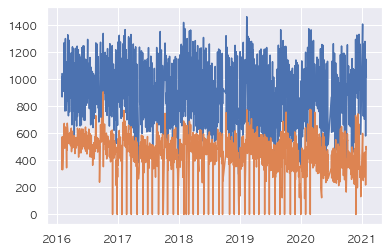

In [1508]:
plt.plot(train['일자'], train['중식계'])
plt.plot(train['일자'], train['석식계'])

plt.show()


## 중식인원과 석식인원 사이에 확연한 차이가 있다는 것을 알 수 있다. 모델을 다르게 설정해야함

In [1509]:
# 외부데이터 가지고 오기

# 기상데이터 가지고 오기(12시에 비 온 데이터 one_hot encoding)(비가 오면 아무래도 사람들이 밖에나가서 밥을 먹기보다는 구내식당에서 밥을 먹을 가능성이 높다는 가정)

rain_train = pd.read_csv("./rain_train.csv")

rain_train['날짜'] = pd.to_datetime(rain_train['일시'])
rain_train['년'] = rain_train['날짜'].dt.year
rain_train['월'] = rain_train['날짜'].dt.month
rain_train['일'] = rain_train['날짜'].dt.day
rain_train['시간'] = rain_train['날짜'].dt.hour

rain_train['TF'] = np.where((rain_train['시간']==12) & (rain_train.iloc[:,3]>=3),1,0)

rain_12 = rain_train[(rain_train['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

train_rain = pd.merge(train, rain_12, on=['년', '월', '일'], how='left')

train_rain.rename(columns={"TF_x":"TF"}, inplace=True)
train = train_rain

# test 데이터 기상데이터 one_hot encoding
rain_test = pd.read_csv("./rain_test.csv")
rain_test
rain_test['날짜'] = pd.to_datetime(rain_test['일시'])
rain_test['년'] = rain_test['날짜'].dt.year
rain_test['월'] = rain_test['날짜'].dt.month
rain_test['일'] = rain_test['날짜'].dt.day
rain_test['시간'] = rain_test['날짜'].dt.hour


rain_test['TF'] = np.where((rain_test['시간']==12) & (rain_test.iloc[:,3]>=3),1,0)

rain_12 = rain_test[(rain_test['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

test_rain = pd.merge(test, rain_12, on=['년', '월', '일'], how='left')

test_rain.rename(columns={"TF_x":"TF"}, inplace=True)
test = test_rain


In [1510]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF'],
      dtype='object')

In [1512]:
# 외부데이터 가지고 오기

# 온도 데이터 불러오기

temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_train = temp[['년', '월', '일', '최고기온(℃)']]
temp_train.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)
train_temp = pd.merge(train, temp_train, on=['년', '월', '일'], how='left')
train = train_temp


temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_test = temp[['년', '월', '일', '최고기온(℃)']]
temp_test.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)

test_temp = pd.merge(test, temp_test, on=['년', '월', '일'], how='left')
test = test_temp

In [1513]:
# 야근에 대한 정보 추출

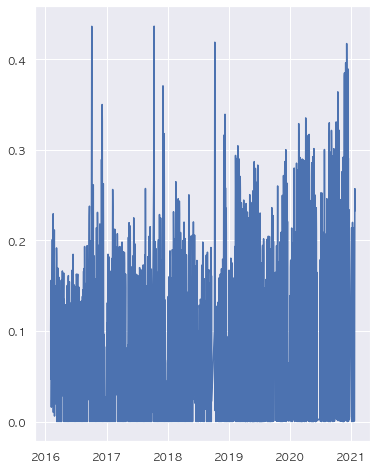

In [1514]:
plt.figure(figsize=(6,8))
plt.plot(train['일자'],train['야근비율'])

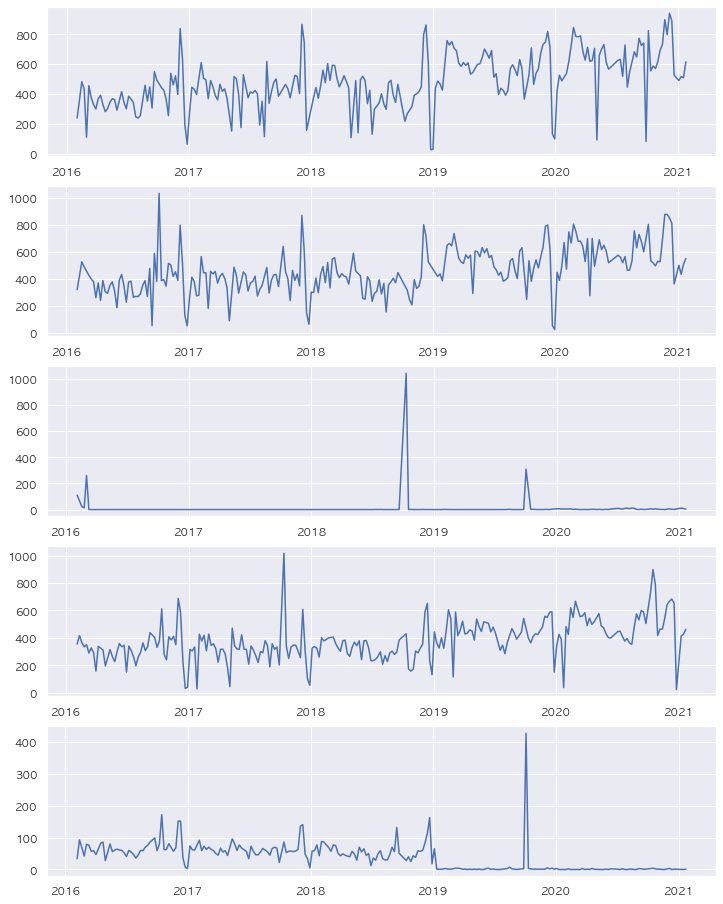

In [1515]:
plt.figure(figsize = (12,16))

train1 = train[train['요일']==0]
plt.subplot(5,1,1)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==1]
plt.subplot(5,1,2)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==2]
plt.subplot(5,1,3)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==3]
plt.subplot(5,1,4)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==4]
plt.subplot(5,1,5)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])
plt.show()

2019년부터 금요일 야근이 확 줄었다.
또한 금요일 그래프에서 아주 극단적인 수치가 나타는데 이를 처리해줘야 할 것.

In [1516]:
# 2019년부터 금요일 야근이 확 줄었다.


train['overwork'] = np.where((train['년'] >= 2019) & (train['요일'] == 4),1,0)
train_overwork = train.loc[:, ['년', '월', '일', 'overwork']]
train_overwork1 = pd.merge(train, train_overwork, on=['년', '월', '일'], how='left')
train_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
train = train_overwork1.iloc[:,0:-1]


test['overwork'] = np.where((test['년'] >= 2019) & (test['요일'] == 4),1,0)
test_overwork = test.loc[:, ['년', '월', '일', 'overwork']]
test_overwork1 = pd.merge(test, test_overwork, on=['년', '월', '일'], how='left')
test_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
test = test_overwork1.iloc[:,0:-1]


In [1517]:
train[(train['요일']==4) & (train['본사시간외근무명령서승인건수']>300)]
# 금요일 300명 이상이 야근 승인을 받은 것은 매우 특이한 케이스이므로 이를 어떻게 처리해야 할지 생각해야 할 것.

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,주,출근,휴가비율,출장비율,야근비율,재택비율,출장휴가재택비율,TF,최고기온,overwork
895,2019-10-04,4,3121,268,231,428,0,모닝롤/치즈프레즐 우유/주스 계란후라이 홍게살죽/쌀밥 (쌀:국내산) 황태국 쥐포...,쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 소불고기 두부양념조림 미역레몬초무침 ...,쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 함박스테이크 계란찜 콩나물무침 포기김치...,...,40,2622,0.08587,0.074015,0.163234,0.0,0.159885,NaN,27.6,1


In [1518]:
# 코로나 상황 고려
# 2020년 02월 27일부로 재택근무가 시작되었다.

train['home'] = np.where((train['일자'] >= "2020-02-26"),1,0)
train_home = train.loc[:, ['년', '월', '일', 'home']]
train_home1 = pd.merge(train, train_home, on=['년', '월', '일'], how='left')
train_home1.rename(columns={'home_x':'home'},inplace=True)
train = train_home1.iloc[:,:-1]

test['home'] = 1

In [1519]:
# 단순 반복 작업 (공휴일 전후, 전전, 후후, 퐁당퐁당 공휴일 변수화하기)

## 공휴일 전/후 데이터 추가 연휴 바로 전 평일 1 / 휴일 다음 날 평일 2 / 휴일 다음다음날3 / 휴일 전전날 4 / 퐁당퐁당 5

train['공휴일전후'] = 0
test['공휴일전후'] = 0
train['공휴일전후'][4] = 1
train['공휴일전후'][5] = 2
train['공휴일전후'][6] = 3
train['공휴일전후'][17] = 5
train['공휴일전후'][18] = 2
train['공휴일전후'][47] = 1
train['공휴일전후'][48] = 2
train['공휴일전후'][62] = 1
train['공휴일전후'][63] = 2
train['공휴일전후'][82] = 1
train['공휴일전후'][83] = 2
train['공휴일전후'][131] = 1
train['공휴일전후'][132] = 2
train['공휴일전후'][151] = 4
train['공휴일전후'][152] = 1
train['공휴일전후'][153] = 2
train['공휴일전후'][162] = 1
train['공휴일전후'][163] = 2
train['공휴일전후'][244] = 4
train['공휴일전후'][245] = 1
train['공휴일전후'][246] = 2
train['공휴일전후'][247] = 3
train['공휴일전후'][266] = 1
train['공휴일전후'][267] = 2
train['공휴일전후'][308] = 4
train['공휴일전후'][309] = 1
train['공휴일전후'][310] = 5
train['공휴일전후'][311] = 5
train['공휴일전후'][312] = 2
train['공휴일전후'][330] = 5
train['공휴일전후'][331] = 2
train['공휴일전후'][379] = 5
train['공휴일전후'][380] = 2
train['공휴일전후'][411] = 4
train['공휴일전후'][412] = 1
train['공휴일전후'][413] = 2
train['공휴일전후'][414] = 3
train['공휴일전후'][466] = 1
train['공휴일전후'][467] = 2
train['공휴일전후'][470] = 1
train['공휴일전후'][471] = 2
train['공휴일전후'][501] = 4
train['공휴일전후'][502] = 1
train['공휴일전후'][503] = 2
train['공휴일전후'][510] = 1
train['공휴일전후'][511] = 5
train['공휴일전후'][555] = 1
train['공휴일전후'][556] = 2
train['공휴일전후'][565] = 5
train['공휴일전후'][566] = 2
train['공휴일전후'][575] = 1
train['공휴일전후'][576] = 2
train['공휴일전후'][579] = 1
train['공휴일전후'][580] = 2
train['공휴일전후'][623] = 1
train['공휴일전후'][624] = 2
train['공휴일전후'][650] = 1
train['공휴일전후'][651] = 5
train['공휴일전후'][652] = 2
train['공휴일전후'][653] = 3
train['공휴일전후'][705] = 5
train['공휴일전후'][706] = 2
train['공휴일전후'][709] = 5
train['공휴일전후'][710] = 2
train['공휴일전후'][732] = 1
train['공휴일전후'][733] = 2
train['공휴일전후'][734] = 1
train['공휴일전후'][748] = 1
train['공휴일전후'][749] = 2
train['공휴일전후'][791] = 2
train['공휴일전후'][792] = 1
train['공휴일전후'][793] = 2
train['공휴일전후'][814] = 4
train['공휴일전후'][815] = 5
train['공휴일전후'][862] = 4
train['공휴일전후'][864] = 5
train['공휴일전후'][881] = 4
train['공휴일전후'][882] = 1
train['공휴일전후'][883] = 2
train['공휴일전후'][897] = 1

train['공휴일전후'][950] = 4
train['공휴일전후'][951] = 1
train['공휴일전후'][952] = 2
train['공휴일전후'][955] = 1
train['공휴일전후'][956] = 2
train['공휴일전후'][970] = 4
train['공휴일전후'][971] = 1
train['공휴일전후'][972] = 2
train['공휴일전후'][973] = 3
train['공휴일전후'][1027] = 1
train['공휴일전후'][1028] = 2
train['공휴일전후'][1036] = 4
train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 5
train['공휴일전후'][1039] = 2
train['공휴일전후'][1099] = 1
train['공휴일전후'][1100] = 2
train['공휴일전후'][1029] = 1
train['공휴일전후'][1030] = 2
train['공휴일전후'][1129] = 4
train['공휴일전후'][1133] = 1
train['공휴일전후'][1134] = 2
train['공휴일전후'][1186] = 4
train['공휴일전후'][1187] = 1
train['공휴일전후'][1188] = 2
test['공휴일전후'][9] = 4
test['공휴일전후'][10] = 1
test['공휴일전후'][11] = 2
test['공휴일전후'][20] = 1
test['공휴일전후'][21] = 2


In [1520]:
train['공휴일전후'].unique()

array([0, 1, 2, 3, 5, 4])

In [1521]:
a = train[train['공휴일전후']==0].loc[:,'중식계'].mean()
b = train[train['공휴일전후']==1].loc[:,'중식계'].mean()
c = train[train['공휴일전후']==2].loc[:,'중식계'].mean()
d = train[train['공휴일전후']==3].loc[:,'중식계'].mean()
e = train[train['공휴일전후']==4].loc[:,'중식계'].mean()
f = train[train['공휴일전후']==5].loc[:,'중식계'].mean()

In [1522]:
print( f'휴일을 공휴하지 않는 날의 중식계 평균은 {a} 이고 연휴 전날의 중식계 평균은 {b}, 연휴 다음날은 {c}, 연휴 다음다음날은 {d}, 연휴 전전날은 {e}, 퐁당퐁당인 날은 {f}') 

휴일을 공휴하지 않는 날의 중식계 평균은 892.1845454545454 이고 연휴 전날의 중식계 평균은 746.1428571428571, 연휴 다음날은 1092.2564102564102, 연휴 다음다음날은 1137.2, 연휴 전전날은 740.1538461538462, 퐁당퐁당인 날은 571.4615384615385


즉, 연휴 전날에는 휴가를 쓰는 직원들이 많고 이에 따라 식수 인원이 줄어드는 경우가 많다. 반대로 연휴가 끝나고 난 직후에는 직원들이 중식당을 평균적으로 많이 찾는다. 특히 퐁당으로 휴일과 휴일 사이에 평일이 하루 끼어있는 경우에는 중식계 평균인원이 급격하게 줄어드는 양상을 보인다.

In [1523]:
# 코로나로 인해 경각심을 가지는 시기 (20년 2말 / 20년 8말 / 20년 12월 1월초) #코로나 확진자 수가 급증하며 확진자수에 대한 대중의 관심이 커지는 시점
# mask_covid = (((train['년'] == 2020) & (train['월']==2) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==3) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==8) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==9) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==11) & (train['일'] >= 23)) |  ((train['년'] == 2020) & (train['월']==12) & (train['일'] <= 23))) | ((train['년'] == 2021) & (train['월']==1) & (train['일'] >=4))

mask_covid = (((train['년'] == 2020) & (train['월'] == 2) & (train['일'] >= 24)) | (
            (train['년'] == 2020) & (train['월'] == 3) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 8) & (train['일'] >= 24)) | (
                          (train['년'] == 2020) & (train['월'] == 9) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 11) & (train['일'] >= 19)) | (
                          (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 24))) | (
                         (train['년'] == 2021) & (train['월'] == 1) & (train['일'] >= 4))

train_covid = train[mask_covid]
train_covid
train_covid['covid'] = 1
train_covid = train_covid.loc[:, ['년', '월', '일', 'covid']]
train_covid1 = pd.merge(train, train_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_covid1.dropna(subset=['요일'], axis=0, inplace=True)
train_covid1['covid'].replace(np.nan, 0, inplace=True)
train = train_covid1
train

test.columns

mask_covid_t = (((test['년'] == 2021) & (test['월'] == 1) & (test['일'] >= 27)) & (
            (test['년'] == 2021) & (test['월'] == 1) & (test['일'] <= 29))) | (
                           ((test['년'] == 2021) & (test['월'] == 2) & (test['일'] >= 15)) & (
                               (test['년'] == 2021) & (test['월'] == 2) & (test['일'] <= 23))) | (
                           ((test['년'] == 2021) & (test['월'] == 4) & (test['일'] >= 6)) & (
                               (test['년'] == 2021) & (test['월'] == 4) & (test['일'] <= 9)))

test_covid = test[mask_covid_t]
test_covid
test_covid['covid'] = 1
test_covid = test_covid.loc[:, ['년', '월', '일', 'covid']]
test_covid1 = pd.merge(test, test_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
test_covid1.dropna(subset=['요일'], axis=0, inplace=True)
test_covid1['covid'].replace(np.nan, 0, inplace=True)
test = test_covid1



In [1524]:
# 과거 매달 마지막 주 수요일 문화의 날 행사 원핫인코딩 / test 데이터에서는 자기계발의 날이 없는것으로 보아 현재는 시행 안하는듯.

train['culture'] = np.where(train['석식계'] == 0,1,0)
train_culture = train.loc[:, ['년', '월', '일', 'culture']]
train_culture1 = pd.merge(train, train_culture, on=['년', '월', '일'], how='left')
train_culture1.rename(columns={'culture_x':'culture'},inplace=True)
train = train_culture1.iloc[:,:-1]


test['culture'] = 0

In [1525]:
# 연말연초에는 약속이 많다

mask_alcho = ((train['년'] == 2016) & (train['월'] == 12) & (train['일'] >= 22)) & (
            (train['년'] == 2016) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 31))

train_alcho = train[mask_alcho]
train_alcho['일자']
train_alcho['alcho'] = 1
train_alcho = train_alcho.loc[:, ['년', '월', '일', 'alcho']]
train_alcho1 = pd.merge(train, train_alcho, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_alcho1.dropna(subset=['요일'], axis=0, inplace=True)
train_alcho1['alcho'].replace(np.nan, 0, inplace=True)
train = train_alcho1
train

test['alcho'] = 0


In [1526]:
train.shape

(1205, 30)

In [1527]:
# 서울시 코로나 확진자 데이터 가져오기

covid = pd.read_csv("./covid.csv")
covid['확진일'] = pd.to_datetime(covid['확진일'])

covid['확진자수'] = 1
covid = covid[['확진일', '확진자수']]
covid1 = covid.groupby(['확진일']).sum()
covid1.reset_index(inplace=True)

datee = pd.date_range('2016-02-01', '2021-04-09')
datee = pd.DataFrame(datee)
datee.rename(columns={0:'날짜'},inplace=True)
covid2 = pd.merge(datee, covid1, left_on=['날짜'],right_on=['확진일'], how='left')



covid3 = covid2[covid2['날짜'].notnull()]
covid3['날짜'] = pd.to_datetime(covid3['날짜'])
covid3['년'] = covid3['날짜'].dt.year
covid3['월'] = covid3['날짜'].dt.month
covid3['일'] = covid3['날짜'].dt.day
covid3 = covid3[['년','월','일', '확진자수']]
covid3['확진자수'].replace(np.nan, 0, inplace=True)

train = pd.merge(train, covid3, on=['년', '월', '일'], how='left')
train.rename(columns={'확진자수_x':'확진자수'},inplace=True)

test = pd.merge(test, covid3, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='left')
test.rename(columns={'확진자수_x':'확진자수'},inplace=True)


## 데이터 transformation 및 스케일링

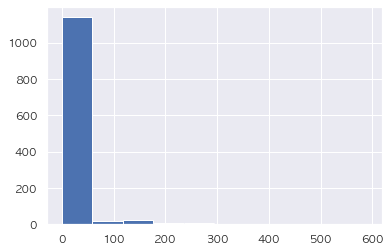

In [1528]:
plt.hist(train['확진자수'])
plt.show()

왜도가 크기 때문에, 확진자수 데이터에 대한 로그변환이 필요할듯.

In [1529]:
#확진자수 로그변환

train['확진자수_log'] = np.log1p(train['확진자수'])
test['확진자수_log'] = np.log1p(test['확진자수'])

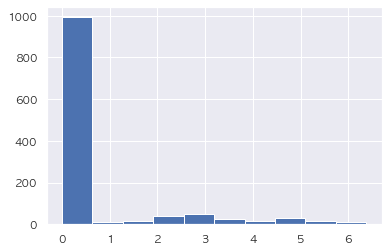

In [1530]:
plt.hist(train['확진자수_log'])
plt.show()

In [1531]:
# 서울시 확진자수 minmaxscaler

minmax = StandardScaler()
total = np.array(train['확진자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['확진자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['확진자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['확진자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')

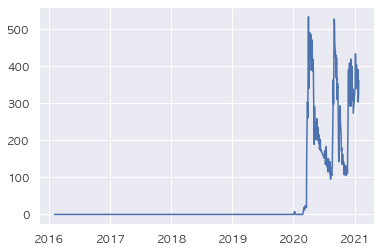

In [1532]:
plt.plot(train['일자'], train['현본사소속재택근무자수'])
plt.show()

In [1533]:
# 현본사소속재택근무자수 minmax scale 하기 (0의 값이 매우 많기 때문에 standardscaler보다는 minmaxscaler를 쓰는게 낫다)

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
total = np.array(train['현본사소속재택근무자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['현본사소속재택근무자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['현본사소속재택근무자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['현본사소속재택근무자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')


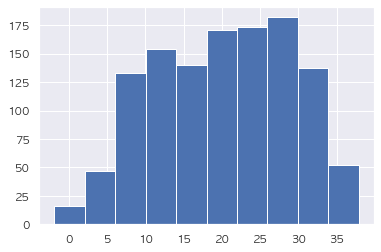

In [1534]:
plt.hist(train['최고기온'])
plt.show()

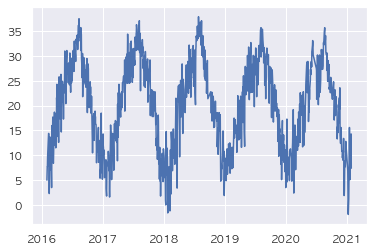

In [1535]:
plt.plot(train['일자'],train['최고기온'])
plt.show()

In [1536]:
# 전주시 최고기온 standardscaler(이상치가 그리 크지 않기 때문에 정규화시킴)

from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['최고기온'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['최고기온_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['최고기온'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['최고기온_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')

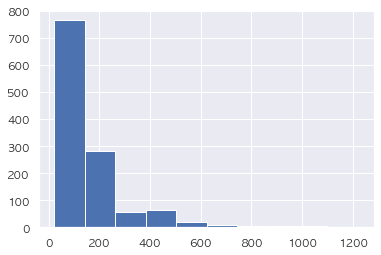

In [1537]:
plt.hist(train['본사휴가자수'])
plt.show()

In [1538]:
train['본사휴가자수_log'] = np.log1p(train['본사휴가자수'])
test['본사휴가자수_log'] = np.log1p(test['본사휴가자수'])

In [1539]:
# 본사 정원수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['출근'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['출근_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"출근_scale_x":"출근"}, inplace = True)

total_test = np.array(test['출근'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['출근_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"출근_scale_x":"출근"}, inplace = True)


# 본사 휴가자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사휴가자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사휴가자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

total_test = np.array(test['본사휴가자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사휴가자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

# 본사출장자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사출장자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사출장자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

total_test = np.array(test['본사출장자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사출장자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

# 본사시간외근무명령서승인건수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사시간외근무명령서승인건수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사시간외근무명령서승인건수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)

total_test = np.array(test['본사시간외근무명령서승인건수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사시간외근무명령서승인건수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)



In [1540]:
# corr 파일에서 본 상관계수가 높은 변수 만들어내기

train['휴가ls2시간외s'] = (train['본사휴가자수_log_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['최고기온s2시간외s'] = (train['최고기온_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['시간외s3'] = (train['본사시간외근무명령서승인건수_scale']) ** 3
train['출장자수s2시간외s'] = (train['본사출장자수_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['출근s2시간외s'] = (train['출근_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])

test['휴가ls2시간외s'] = (test['본사휴가자수_log_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['최고기온s2시간외s'] = (test['최고기온_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['시간외s3'] = (test['본사시간외근무명령서승인건수_scale']) ** 3
test['출장자수s2시간외s'] = (test['본사출장자수_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['출근s2시간외s'] = (test['출근_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])


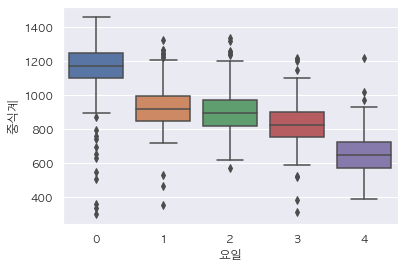

In [1541]:
sns.boxplot(x='요일', y='중식계', data=train)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd13f783d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd13f78af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd13f78040>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd13f82250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd13f825e0>],
 'means': []}

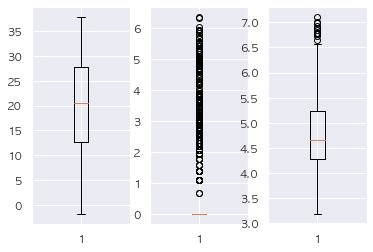

In [1542]:
# 이상치제거
plt.subplot(1,3,1)
plt.boxplot(train.최고기온)
plt.subplot(1,3,2)
plt.boxplot(train.확진자수_log)
plt.subplot(1,3,3)
plt.boxplot(train.본사휴가자수_log)

<AxesSubplot:xlabel='요일', ylabel='본사시간외근무명령서승인건수'>

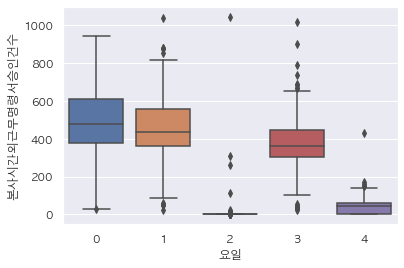

In [1543]:
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data = train)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd12fe2460>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd12fe2b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd12fe20d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd12fe02e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd12fe0670>],
 'means': []}

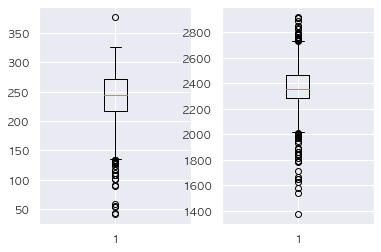

In [1544]:
plt.subplot(1,2,1)
plt.boxplot(train.본사출장자수)
plt.subplot(1,2,2)
plt.boxplot(train.출근)

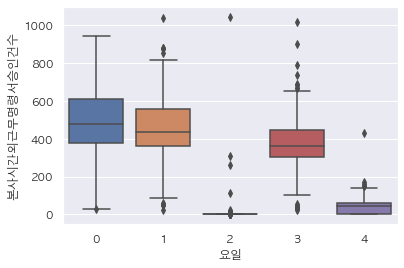

In [1545]:
# IQR을 사용해서 이상치 제거하기
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data=train)

# 월
iqr = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 0].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 0].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 0][mask_time]
List = list(train_outliers.index)
List  # 705 실제 train 데이터에서 엑셀 기준 707

for i in List:
    train.drop(index=i, inplace=True)

# 화 (실제로 예측해야할 데이터들이 화요일에 야근이 많다 따라서 크다고 여겨지는 이상치는 이상치가 아니다)
iqr = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 1].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 1][mask_time]
List = list(train_outliers.index)
List  # 152, 163, 223, 453*, 467, 951, 955, 1165*, 1170*, 1175* *별표는 큰 이상치

for i in List:
    train.drop(index=i, inplace=True)

# 수
iqr = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 2].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 2].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 2][mask_time]
List = list(train_outliers.index)
List  # 세자리, 네자리 수인 2,9,14,18 만 지우겠다.

train.drop(index=2, inplace=True)
train.drop(index=18, inplace=True)
train.drop(index=652, inplace=True)
train.drop(index=894, inplace=True)

# 목
iqr = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List

for i in List:
    train.drop(index=i, inplace=True)

mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 > upper)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List  # 415, 1137

train.drop(index=415, inplace=True)
train.drop(index=1137, inplace=True)

# 금
iqr = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 4].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 4].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 4][mask_time]
List = list(train_outliers.index)
List  # 400이상인 895번 index만 삭제한다.

train.drop(index=895, inplace=True)

train_lunch = train
train_dinner = train
test_lunch = test
test_dinner = test

# train dinner에서 결측치 이상치 제거하기

mask_oo = train_dinner['일자'] != '2017-09-27'
train_dinner = train_dinner[mask_oo]
mask_ooo = train_dinner['일자'] != '2018-02-14'
train_dinner = train_dinner[mask_ooo]
train_dinner

mask_0 = train_dinner['석식계'] != 0
train_dinner = train_dinner[mask_0]
train_dinner

mask_0 = train_dinner['석식계']!=0
train_dinner = train_dinner[mask_0]
train_dinner
 
train_dinner['야근제외석식'] = train_dinner['석식계']-train_dinner['본사시간외근무명령서승인건수']
#plt.plot(train_dinner.index, train_dinner.야근제외석식)
 
train_dinner['석식계'].skew()
train_dinner['석식계'].kurt()
#plt.hist(train_dinner['석식계'], bins=15, alpha=0.5)
 
 
 
#월화목/ 수금 분리

mask_day = (train_dinner['요일']==0) |  (train_dinner['요일']==1) | (train_dinner['요일']==3)  
train_dinner_mtt = train_dinner[mask_day]
 
mask_day = (train_dinner['요일']==2) |  (train_dinner['요일']==4)   
train_dinner_wf = train_dinner[mask_day]

mask_day = (test_dinner['요일']==0) |  (test_dinner['요일']==1) | (test_dinner['요일']==3)  
test_dinner_mtt = test_dinner[mask_day]
 
mask_day = (test_dinner['요일']==2) |  (test_dinner['요일']==4)   
test_dinner_wf = test_dinner[mask_day]


In [1546]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF', '최고기온',
       'overwork', 'home', '공휴일전후', 'covid', 'culture', 'alcho', '확진자수',
       '확진자수_log', '확진자수_log_scale', '현본사소속재택근무자수_scale', '최고기온_scale',
       '본사휴가자수_log', '출근_scale', '본사휴가자수_log_scale', '본사출장자수_scale',
       '본사시간외근무명령서승인건수_scale', '휴가ls2시간외s', '최고기온s2시간외s', '시간외s3',
       '출장자수s2시간외s', '출근s2시간외s'],
      dtype='object')

In [1547]:
#Catboost 모델 적합

In [1548]:
from catboost import CatBoostRegressor
from imblearn.over_sampling import SMOTE

## oversampling

In [1549]:
# 2020년도 데이터를 증폭시켜서 비중을 비슷하게 만든 다음 21년도를 예측해보자.

# 제일 마지막 case만 round를 실제로 해준 것과 같다.

# TF 값을 지웠다.


#cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
 #                   '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
  #                  '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]


cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale'
                     ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]

train_lunch_home = train_lunch[['home']].iloc[:1169]
train_lunch_home = train_lunch_home['home'].astype('category')


In [1550]:
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())

In [1551]:
cc4_total =pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total =cc4_total.iloc[: ,-1]
cc4_total_cut = cc4_total.iloc[: ,0:cc2.shape[1]-1]


cc4_total['요일'] = cc4_total['요일'].round()
cc4_total['공휴일전후'] = cc4_total['공휴일전후'].round()
cc4_total['월'] = cc4_total['월'].round()
#cc4_total['TF'] = cc4_total['TF'].round()

cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()

#cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
#                    '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
#                    '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]

#중요변수 탐색 이후 feature 변환

cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]


cc5_1 = train_lunch[['중식계']].iloc[1169:]

In [1552]:
cc4_total_cut

,본사휴가자수_log_scale,본사출장자수_scale,최고기온_scale,휴가ls2시간외s,현본사소속재택근무자수_scale,확진자수_log_scale,최고기온s2시간외s,요일,공휴일전후,월
0,-1.301957,-2.094550,-1.700966,-0.248730,0.000000,-0.422069,-0.424546,0,0,2
1,-1.301957,-1.565987,-1.565977,0.309099,0.000000,-0.422069,0.447172,1,0,2
2,-0.227628,-0.485881,-1.397240,0.017027,0.000000,-0.422069,0.641537,3,0,2
3,1.226242,-1.382140,-1.183507,-1.466890,0.000000,-0.422069,-1.366429,4,1,2
4,1.701463,-2.255417,-0.643551,1.680537,0.000000,-0.422069,0.240419,3,2,2
...,...,...,...,...,...,...,...,...,...,...
1945,-0.335927,-0.405112,0.269599,0.226648,0.511441,0.291739,0.084650,1,1,5
1946,-0.770004,0.603849,0.182589,-0.715310,0.319058,1.781273,-0.043262,2,0,10
1947,-0.506951,-0.613701,-0.356751,0.382457,0.266048,0.746327,1.407186,2,0,4
1948,0.914382,0.843741,0.372339,-0.931796,0.384573,0.614240,-0.176074,4,0,5


## Catboost

In [1553]:
model = CatBoostRegressor(iterations=96, learning_rate=0.18, depth=4, l2_leaf_reg=30, subsample=1, eval_metric='MAE', od_type='IncToDec', random_seed=42, allow_writing_files=False)

In [1554]:
model.fit(cc4_total_cut ,cc5_total, verbose=0)

In [1555]:
from sklearn.model_selection import cross_val_score

model.score(cc4_total_cut ,cc5_total)
cv_results = cross_val_score(model, cc4_total_cut ,cc5_total ,cv=10, scoring='neg_mean_absolute_error')


0:	learn: 158.6260685	total: 1.02ms	remaining: 97.3ms
1:	learn: 143.0027794	total: 2.48ms	remaining: 117ms
2:	learn: 132.1167366	total: 3.57ms	remaining: 111ms
3:	learn: 120.6793845	total: 4.61ms	remaining: 106ms
4:	learn: 112.2031953	total: 5.61ms	remaining: 102ms
5:	learn: 104.1984915	total: 6.62ms	remaining: 99.3ms
6:	learn: 98.1574532	total: 7.53ms	remaining: 95.7ms
7:	learn: 93.4478663	total: 8.53ms	remaining: 93.8ms
8:	learn: 89.5659563	total: 9.51ms	remaining: 91.9ms
9:	learn: 86.3945536	total: 10.5ms	remaining: 90.2ms
10:	learn: 83.1779358	total: 11.5ms	remaining: 88.8ms
11:	learn: 80.6929983	total: 12.5ms	remaining: 87.6ms
12:	learn: 78.5726421	total: 13.6ms	remaining: 86.6ms
13:	learn: 76.3900613	total: 14.7ms	remaining: 86ms
14:	learn: 75.1470254	total: 15.6ms	remaining: 84.4ms
15:	learn: 74.0044709	total: 16.6ms	remaining: 82.8ms
16:	learn: 73.6800497	total: 17.6ms	remaining: 81.8ms
17:	learn: 72.8677970	total: 18.6ms	remaining: 80.7ms
18:	learn: 71.6488026	total: 19.6ms	re

0:	learn: 156.5327773	total: 956us	remaining: 90.9ms
1:	learn: 141.6856069	total: 2.1ms	remaining: 98.9ms
2:	learn: 129.8848717	total: 3.06ms	remaining: 94.9ms
3:	learn: 120.6007746	total: 4.03ms	remaining: 92.7ms
4:	learn: 111.7647960	total: 5.01ms	remaining: 91.3ms
5:	learn: 104.0228786	total: 6.05ms	remaining: 90.7ms
6:	learn: 97.1948031	total: 7.05ms	remaining: 89.7ms
7:	learn: 92.1446643	total: 8.01ms	remaining: 88.1ms
8:	learn: 88.4199392	total: 8.95ms	remaining: 86.5ms
9:	learn: 85.3118575	total: 10.1ms	remaining: 86.6ms
10:	learn: 81.7361812	total: 11.1ms	remaining: 85.4ms
11:	learn: 79.0049440	total: 12ms	remaining: 83.8ms
12:	learn: 76.8869974	total: 12.9ms	remaining: 82.2ms
13:	learn: 75.0805734	total: 13.8ms	remaining: 80.9ms
14:	learn: 73.8102284	total: 14.7ms	remaining: 79.6ms
15:	learn: 72.9342265	total: 15.7ms	remaining: 78.3ms
16:	learn: 71.7283442	total: 16.6ms	remaining: 77.1ms
17:	learn: 71.0942267	total: 17.5ms	remaining: 76ms
18:	learn: 70.1863560	total: 18.5ms	re

74:	learn: 57.5204010	total: 62.3ms	remaining: 17.4ms
75:	learn: 57.4613791	total: 63.8ms	remaining: 16.8ms
76:	learn: 57.4468465	total: 64.8ms	remaining: 16ms
77:	learn: 57.4003390	total: 66.2ms	remaining: 15.3ms
78:	learn: 57.3452875	total: 67.2ms	remaining: 14.5ms
79:	learn: 57.2800247	total: 68.2ms	remaining: 13.6ms
80:	learn: 57.2691052	total: 69ms	remaining: 12.8ms
81:	learn: 57.1470570	total: 71.4ms	remaining: 12.2ms
82:	learn: 56.7946635	total: 72.3ms	remaining: 11.3ms
83:	learn: 56.5325704	total: 73.3ms	remaining: 10.5ms
84:	learn: 56.4936830	total: 74.1ms	remaining: 9.6ms
85:	learn: 55.9596458	total: 75.1ms	remaining: 8.73ms
86:	learn: 55.8518782	total: 76.1ms	remaining: 7.87ms
87:	learn: 55.7644027	total: 77ms	remaining: 7ms
88:	learn: 55.6370117	total: 77.9ms	remaining: 6.13ms
89:	learn: 55.6027779	total: 78.9ms	remaining: 5.26ms
90:	learn: 55.5444398	total: 79.9ms	remaining: 4.39ms
91:	learn: 55.4516723	total: 80.8ms	remaining: 3.51ms
92:	learn: 55.4239901	total: 81.7ms	re

81:	learn: 57.7480495	total: 63.3ms	remaining: 10.8ms
82:	learn: 57.5414979	total: 64.3ms	remaining: 10.1ms
83:	learn: 57.4489213	total: 65.7ms	remaining: 9.39ms
84:	learn: 57.2065566	total: 66.6ms	remaining: 8.62ms
85:	learn: 56.9936192	total: 67.7ms	remaining: 7.87ms
86:	learn: 56.8287766	total: 68.7ms	remaining: 7.1ms
87:	learn: 56.7810173	total: 69.6ms	remaining: 6.32ms
88:	learn: 56.5532690	total: 70.6ms	remaining: 5.55ms
89:	learn: 56.5342228	total: 71.4ms	remaining: 4.76ms
90:	learn: 56.4906625	total: 72.4ms	remaining: 3.98ms
91:	learn: 56.4682175	total: 73.3ms	remaining: 3.19ms
92:	learn: 56.3762636	total: 74.3ms	remaining: 2.4ms
93:	learn: 56.3555906	total: 75.3ms	remaining: 1.6ms
94:	learn: 56.2947559	total: 76.2ms	remaining: 802us
95:	learn: 56.1418879	total: 77.2ms	remaining: 0us
0:	learn: 155.8724212	total: 935us	remaining: 88.9ms
1:	learn: 141.5339848	total: 2.02ms	remaining: 95.1ms
2:	learn: 131.7635012	total: 3.04ms	remaining: 94.3ms
3:	learn: 121.3666397	total: 4.1ms	r

85:	learn: 58.0322963	total: 69.5ms	remaining: 8.09ms
86:	learn: 58.0093776	total: 70.4ms	remaining: 7.29ms
87:	learn: 57.7458765	total: 71.8ms	remaining: 6.53ms
88:	learn: 57.5433581	total: 72.8ms	remaining: 5.73ms
89:	learn: 57.4353114	total: 73.7ms	remaining: 4.91ms
90:	learn: 57.3849383	total: 74.8ms	remaining: 4.11ms
91:	learn: 57.2441474	total: 75.7ms	remaining: 3.29ms
92:	learn: 57.0796590	total: 76.7ms	remaining: 2.47ms
93:	learn: 56.8676273	total: 77.6ms	remaining: 1.65ms
94:	learn: 56.7195658	total: 78.4ms	remaining: 825us
95:	learn: 56.5601978	total: 79.3ms	remaining: 0us
0:	learn: 156.0620191	total: 894us	remaining: 85ms
1:	learn: 141.0017391	total: 1.75ms	remaining: 82.5ms
2:	learn: 131.0991372	total: 2.63ms	remaining: 81.5ms
3:	learn: 120.2345240	total: 3.72ms	remaining: 85.6ms
4:	learn: 112.2812231	total: 4.79ms	remaining: 87.1ms
5:	learn: 104.5480442	total: 5.76ms	remaining: 86.4ms
6:	learn: 98.8152836	total: 6.76ms	remaining: 85.9ms
7:	learn: 94.3021529	total: 7.63ms	r

94:	learn: 57.0441256	total: 74.1ms	remaining: 779us
95:	learn: 57.0388473	total: 75ms	remaining: 0us


In [1556]:
pd.Series(model.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

요일                   44.388337
본사출장자수_scale         20.981226
본사휴가자수_log_scale     10.761070
휴가ls2시간외s             5.647059
확진자수_log_scale        4.553076
최고기온_scale            3.572569
현본사소속재택근무자수_scale     3.320418
월                     2.631044
최고기온s2시간외s            2.569503
공휴일전후                 1.575697
dtype: float64

In [1557]:
test_data_lunch = test_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월']]

In [1558]:
lunch_prediction = model.predict(test_data_lunch)

In [1559]:
train_dinner.shape

(1143, 46)

In [1560]:
cc2 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                    '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                    '휴가ls2시간외s', '시간외s3',
                    '월', '석식계']].iloc[:1133]

train_dinner_home = train_dinner[['home']].iloc[:1133]
train_dinner_home = train_dinner_home['home'].astype('category')

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total = pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total = cc4_total.iloc[:, -1]
cc4_total_cut = cc4_total.iloc[:, 0:cc2.shape[1] - 1]


In [1561]:
#cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

cc4_1 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월', ]].iloc[1133:]

cc5_1 = train_dinner[['석식계']].iloc[1133:]

In [1562]:
model2 = CatBoostRegressor(iterations=1700, learning_rate=0.01, depth=4, l2_leaf_reg=25, subsample=1, eval_metric='MAE',
                          od_type='IncToDec', random_seed=42, allow_writing_files=False)
model2.fit(cc4_total_cut, cc5_total, verbose=0)

In [1563]:
from sklearn.model_selection import KFold

model2.score(cc4_total_cut, cc5_total)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model2, cc4_total_cut, cc5_total, cv=10)

0:	learn: 93.7023439	total: 1ms	remaining: 1.71s
1:	learn: 93.2000545	total: 2.27ms	remaining: 1.93s
2:	learn: 92.7536907	total: 3.11ms	remaining: 1.76s
3:	learn: 92.2715102	total: 3.95ms	remaining: 1.67s
4:	learn: 91.8048534	total: 4.91ms	remaining: 1.66s
5:	learn: 91.3090438	total: 5.85ms	remaining: 1.65s
6:	learn: 90.8353111	total: 6.68ms	remaining: 1.61s
7:	learn: 90.3662745	total: 7.64ms	remaining: 1.61s
8:	learn: 89.9166542	total: 8.58ms	remaining: 1.61s
9:	learn: 89.4633742	total: 9.52ms	remaining: 1.61s
10:	learn: 89.0110224	total: 10.5ms	remaining: 1.6s
11:	learn: 88.5587770	total: 11.4ms	remaining: 1.6s
12:	learn: 88.1143804	total: 12.7ms	remaining: 1.65s
13:	learn: 87.7336713	total: 13.7ms	remaining: 1.65s
14:	learn: 87.3588186	total: 14.7ms	remaining: 1.65s
15:	learn: 86.9963594	total: 15.7ms	remaining: 1.65s
16:	learn: 86.6038581	total: 16.6ms	remaining: 1.64s
17:	learn: 86.2202298	total: 17.5ms	remaining: 1.64s
18:	learn: 85.8125359	total: 18.5ms	remaining: 1.64s
19:	lear

220:	learn: 51.8238601	total: 184ms	remaining: 1.23s
221:	learn: 51.7741586	total: 185ms	remaining: 1.23s
222:	learn: 51.7164100	total: 186ms	remaining: 1.23s
223:	learn: 51.6722484	total: 187ms	remaining: 1.23s
224:	learn: 51.6085728	total: 188ms	remaining: 1.24s
225:	learn: 51.5378182	total: 189ms	remaining: 1.23s
226:	learn: 51.4638566	total: 190ms	remaining: 1.23s
227:	learn: 51.4030946	total: 191ms	remaining: 1.23s
228:	learn: 51.3348760	total: 192ms	remaining: 1.23s
229:	learn: 51.2735731	total: 193ms	remaining: 1.23s
230:	learn: 51.2209179	total: 194ms	remaining: 1.23s
231:	learn: 51.1688575	total: 195ms	remaining: 1.23s
232:	learn: 51.1100902	total: 196ms	remaining: 1.23s
233:	learn: 51.0539805	total: 197ms	remaining: 1.23s
234:	learn: 51.0078157	total: 198ms	remaining: 1.23s
235:	learn: 50.9640066	total: 199ms	remaining: 1.23s
236:	learn: 50.9221195	total: 200ms	remaining: 1.23s
237:	learn: 50.8732956	total: 201ms	remaining: 1.23s
238:	learn: 50.8314282	total: 202ms	remaining:

387:	learn: 45.4331729	total: 364ms	remaining: 1.23s
388:	learn: 45.4148692	total: 366ms	remaining: 1.23s
389:	learn: 45.3893810	total: 369ms	remaining: 1.24s
390:	learn: 45.3696447	total: 373ms	remaining: 1.25s
391:	learn: 45.3343694	total: 375ms	remaining: 1.25s
392:	learn: 45.3108828	total: 376ms	remaining: 1.25s
393:	learn: 45.2913045	total: 379ms	remaining: 1.26s
394:	learn: 45.2726458	total: 381ms	remaining: 1.26s
395:	learn: 45.2491063	total: 383ms	remaining: 1.26s
396:	learn: 45.2315837	total: 384ms	remaining: 1.26s
397:	learn: 45.2145832	total: 388ms	remaining: 1.27s
398:	learn: 45.1852947	total: 390ms	remaining: 1.27s
399:	learn: 45.1563535	total: 395ms	remaining: 1.28s
400:	learn: 45.1314875	total: 398ms	remaining: 1.29s
401:	learn: 45.1115389	total: 400ms	remaining: 1.29s
402:	learn: 45.0840181	total: 402ms	remaining: 1.29s
403:	learn: 45.0701331	total: 403ms	remaining: 1.29s
404:	learn: 45.0435848	total: 405ms	remaining: 1.3s
405:	learn: 45.0292257	total: 406ms	remaining: 

625:	learn: 41.9980090	total: 892ms	remaining: 1.53s
626:	learn: 41.9839573	total: 893ms	remaining: 1.53s
627:	learn: 41.9797964	total: 894ms	remaining: 1.53s
628:	learn: 41.9666034	total: 896ms	remaining: 1.52s
629:	learn: 41.9577974	total: 897ms	remaining: 1.52s
630:	learn: 41.9512707	total: 898ms	remaining: 1.52s
631:	learn: 41.9388009	total: 899ms	remaining: 1.52s
632:	learn: 41.9289064	total: 899ms	remaining: 1.52s
633:	learn: 41.9181727	total: 901ms	remaining: 1.51s
634:	learn: 41.9050858	total: 902ms	remaining: 1.51s
635:	learn: 41.9031567	total: 903ms	remaining: 1.51s
636:	learn: 41.8986654	total: 904ms	remaining: 1.51s
637:	learn: 41.8903014	total: 905ms	remaining: 1.5s
638:	learn: 41.8769308	total: 906ms	remaining: 1.5s
639:	learn: 41.8688814	total: 906ms	remaining: 1.5s
640:	learn: 41.8588872	total: 907ms	remaining: 1.5s
641:	learn: 41.8408995	total: 908ms	remaining: 1.5s
642:	learn: 41.8296494	total: 909ms	remaining: 1.49s
643:	learn: 41.8261040	total: 910ms	remaining: 1.49

948:	learn: 39.9149786	total: 1.24s	remaining: 984ms
949:	learn: 39.9098129	total: 1.24s	remaining: 983ms
950:	learn: 39.9044732	total: 1.25s	remaining: 981ms
951:	learn: 39.8983243	total: 1.25s	remaining: 980ms
952:	learn: 39.8968483	total: 1.25s	remaining: 978ms
953:	learn: 39.8875653	total: 1.25s	remaining: 976ms
954:	learn: 39.8758808	total: 1.25s	remaining: 975ms
955:	learn: 39.8705762	total: 1.25s	remaining: 973ms
956:	learn: 39.8655943	total: 1.25s	remaining: 972ms
957:	learn: 39.8536608	total: 1.25s	remaining: 971ms
958:	learn: 39.8435772	total: 1.25s	remaining: 969ms
959:	learn: 39.8342503	total: 1.25s	remaining: 967ms
960:	learn: 39.8271256	total: 1.25s	remaining: 966ms
961:	learn: 39.8160916	total: 1.26s	remaining: 964ms
962:	learn: 39.8069730	total: 1.26s	remaining: 963ms
963:	learn: 39.8051860	total: 1.26s	remaining: 961ms
964:	learn: 39.8023576	total: 1.26s	remaining: 959ms
965:	learn: 39.7976998	total: 1.26s	remaining: 958ms
966:	learn: 39.7905901	total: 1.26s	remaining:

1106:	learn: 38.9798249	total: 1.41s	remaining: 758ms
1107:	learn: 38.9697221	total: 1.42s	remaining: 757ms
1108:	learn: 38.9608262	total: 1.42s	remaining: 756ms
1109:	learn: 38.9557791	total: 1.42s	remaining: 755ms
1110:	learn: 38.9499510	total: 1.42s	remaining: 754ms
1111:	learn: 38.9465837	total: 1.43s	remaining: 754ms
1112:	learn: 38.9409448	total: 1.43s	remaining: 754ms
1113:	learn: 38.9366055	total: 1.43s	remaining: 753ms
1114:	learn: 38.9247865	total: 1.43s	remaining: 752ms
1115:	learn: 38.9150175	total: 1.43s	remaining: 750ms
1116:	learn: 38.9134871	total: 1.44s	remaining: 749ms
1117:	learn: 38.9091573	total: 1.44s	remaining: 748ms
1118:	learn: 38.9079161	total: 1.44s	remaining: 746ms
1119:	learn: 38.9063970	total: 1.44s	remaining: 745ms
1120:	learn: 38.9032567	total: 1.44s	remaining: 743ms
1121:	learn: 38.8991233	total: 1.44s	remaining: 742ms
1122:	learn: 38.8885433	total: 1.44s	remaining: 741ms
1123:	learn: 38.8870296	total: 1.44s	remaining: 739ms
1124:	learn: 38.8839043	tota

1310:	learn: 37.9645375	total: 1.76s	remaining: 524ms
1311:	learn: 37.9599721	total: 1.77s	remaining: 522ms
1312:	learn: 37.9538280	total: 1.77s	remaining: 521ms
1313:	learn: 37.9434563	total: 1.77s	remaining: 520ms
1314:	learn: 37.9406742	total: 1.77s	remaining: 518ms
1315:	learn: 37.9383718	total: 1.77s	remaining: 517ms
1316:	learn: 37.9356061	total: 1.78s	remaining: 517ms
1317:	learn: 37.9309112	total: 1.78s	remaining: 516ms
1318:	learn: 37.9206677	total: 1.78s	remaining: 515ms
1319:	learn: 37.9184442	total: 1.79s	remaining: 515ms
1320:	learn: 37.9142088	total: 1.79s	remaining: 514ms
1321:	learn: 37.9119234	total: 1.79s	remaining: 513ms
1322:	learn: 37.9054029	total: 1.79s	remaining: 511ms
1323:	learn: 37.8952649	total: 1.79s	remaining: 510ms
1324:	learn: 37.8930524	total: 1.8s	remaining: 508ms
1325:	learn: 37.8900093	total: 1.8s	remaining: 507ms
1326:	learn: 37.8883055	total: 1.8s	remaining: 505ms
1327:	learn: 37.8866071	total: 1.8s	remaining: 504ms
1328:	learn: 37.8782578	total: 1

1469:	learn: 37.3360363	total: 1.95s	remaining: 305ms
1470:	learn: 37.3317242	total: 1.95s	remaining: 304ms
1471:	learn: 37.3298242	total: 1.96s	remaining: 303ms
1472:	learn: 37.3245339	total: 1.96s	remaining: 302ms
1473:	learn: 37.3216926	total: 1.96s	remaining: 301ms
1474:	learn: 37.3191349	total: 1.96s	remaining: 299ms
1475:	learn: 37.3163254	total: 1.97s	remaining: 299ms
1476:	learn: 37.3145109	total: 1.97s	remaining: 297ms
1477:	learn: 37.3121039	total: 1.97s	remaining: 296ms
1478:	learn: 37.3090227	total: 1.97s	remaining: 295ms
1479:	learn: 37.3053406	total: 1.97s	remaining: 293ms
1480:	learn: 37.3003350	total: 1.98s	remaining: 292ms
1481:	learn: 37.2987339	total: 1.98s	remaining: 291ms
1482:	learn: 37.2916785	total: 1.98s	remaining: 289ms
1483:	learn: 37.2888453	total: 1.98s	remaining: 288ms
1484:	learn: 37.2838805	total: 1.98s	remaining: 287ms
1485:	learn: 37.2761249	total: 1.98s	remaining: 286ms
1486:	learn: 37.2698718	total: 1.98s	remaining: 284ms
1487:	learn: 37.2670336	tota

30:	learn: 83.4568217	total: 59.3ms	remaining: 3.19s
31:	learn: 83.1655209	total: 60.7ms	remaining: 3.17s
32:	learn: 82.8421860	total: 62ms	remaining: 3.13s
33:	learn: 82.5242320	total: 62.7ms	remaining: 3.07s
34:	learn: 82.1904296	total: 63.7ms	remaining: 3.03s
35:	learn: 81.9089217	total: 66.6ms	remaining: 3.08s
36:	learn: 81.5915419	total: 70.5ms	remaining: 3.17s
37:	learn: 81.2730159	total: 72.6ms	remaining: 3.17s
38:	learn: 81.0132494	total: 77.1ms	remaining: 3.29s
39:	learn: 80.7312072	total: 83.1ms	remaining: 3.45s
40:	learn: 80.4851260	total: 87.2ms	remaining: 3.53s
41:	learn: 80.1521347	total: 89.5ms	remaining: 3.53s
42:	learn: 79.8603755	total: 91.6ms	remaining: 3.53s
43:	learn: 79.5914236	total: 92.9ms	remaining: 3.49s
44:	learn: 79.2678843	total: 94ms	remaining: 3.46s
45:	learn: 79.0191276	total: 95.5ms	remaining: 3.43s
46:	learn: 78.7713224	total: 96.4ms	remaining: 3.39s
47:	learn: 78.4691687	total: 97.3ms	remaining: 3.35s
48:	learn: 78.1674154	total: 98.1ms	remaining: 3.3

311:	learn: 49.1209602	total: 432ms	remaining: 1.92s
312:	learn: 49.0905826	total: 434ms	remaining: 1.92s
313:	learn: 49.0421157	total: 435ms	remaining: 1.92s
314:	learn: 49.0006314	total: 436ms	remaining: 1.92s
315:	learn: 48.9577743	total: 439ms	remaining: 1.92s
316:	learn: 48.9268465	total: 441ms	remaining: 1.92s
317:	learn: 48.8861427	total: 446ms	remaining: 1.94s
318:	learn: 48.8591808	total: 448ms	remaining: 1.94s
319:	learn: 48.8261161	total: 449ms	remaining: 1.94s
320:	learn: 48.7806954	total: 451ms	remaining: 1.94s
321:	learn: 48.7551971	total: 453ms	remaining: 1.94s
322:	learn: 48.7167977	total: 454ms	remaining: 1.94s
323:	learn: 48.6788098	total: 456ms	remaining: 1.94s
324:	learn: 48.6236420	total: 457ms	remaining: 1.93s
325:	learn: 48.5948182	total: 459ms	remaining: 1.93s
326:	learn: 48.5493081	total: 460ms	remaining: 1.93s
327:	learn: 48.5040539	total: 461ms	remaining: 1.93s
328:	learn: 48.4745602	total: 464ms	remaining: 1.93s
329:	learn: 48.4478104	total: 466ms	remaining:

490:	learn: 44.8343868	total: 765ms	remaining: 1.88s
491:	learn: 44.8113919	total: 767ms	remaining: 1.88s
492:	learn: 44.7896391	total: 768ms	remaining: 1.88s
493:	learn: 44.7806707	total: 771ms	remaining: 1.88s
494:	learn: 44.7648031	total: 773ms	remaining: 1.88s
495:	learn: 44.7437658	total: 774ms	remaining: 1.88s
496:	learn: 44.7289225	total: 775ms	remaining: 1.88s
497:	learn: 44.7187087	total: 776ms	remaining: 1.87s
498:	learn: 44.7104467	total: 777ms	remaining: 1.87s
499:	learn: 44.6931932	total: 778ms	remaining: 1.87s
500:	learn: 44.6782860	total: 779ms	remaining: 1.86s
501:	learn: 44.6611677	total: 781ms	remaining: 1.86s
502:	learn: 44.6396072	total: 782ms	remaining: 1.86s
503:	learn: 44.6338084	total: 783ms	remaining: 1.86s
504:	learn: 44.6216056	total: 784ms	remaining: 1.85s
505:	learn: 44.6064300	total: 787ms	remaining: 1.86s
506:	learn: 44.5954978	total: 788ms	remaining: 1.85s
507:	learn: 44.5675705	total: 789ms	remaining: 1.85s
508:	learn: 44.5597311	total: 790ms	remaining:

698:	learn: 42.4784671	total: 1.13s	remaining: 1.62s
699:	learn: 42.4753372	total: 1.14s	remaining: 1.62s
700:	learn: 42.4685597	total: 1.14s	remaining: 1.62s
701:	learn: 42.4615056	total: 1.14s	remaining: 1.62s
702:	learn: 42.4456128	total: 1.14s	remaining: 1.61s
703:	learn: 42.4416910	total: 1.14s	remaining: 1.61s
704:	learn: 42.4394810	total: 1.14s	remaining: 1.61s
705:	learn: 42.4346248	total: 1.14s	remaining: 1.61s
706:	learn: 42.4325520	total: 1.14s	remaining: 1.6s
707:	learn: 42.4135135	total: 1.14s	remaining: 1.6s
708:	learn: 42.4070229	total: 1.15s	remaining: 1.6s
709:	learn: 42.4056475	total: 1.15s	remaining: 1.6s
710:	learn: 42.3994155	total: 1.15s	remaining: 1.6s
711:	learn: 42.3915311	total: 1.15s	remaining: 1.6s
712:	learn: 42.3853836	total: 1.15s	remaining: 1.59s
713:	learn: 42.3749760	total: 1.15s	remaining: 1.59s
714:	learn: 42.3630038	total: 1.15s	remaining: 1.59s
715:	learn: 42.3479604	total: 1.15s	remaining: 1.59s
716:	learn: 42.3389694	total: 1.16s	remaining: 1.58s

926:	learn: 41.1853986	total: 1.48s	remaining: 1.23s
927:	learn: 41.1844298	total: 1.48s	remaining: 1.23s
928:	learn: 41.1777743	total: 1.48s	remaining: 1.23s
929:	learn: 41.1764281	total: 1.48s	remaining: 1.23s
930:	learn: 41.1753821	total: 1.49s	remaining: 1.23s
931:	learn: 41.1742060	total: 1.49s	remaining: 1.23s
932:	learn: 41.1680700	total: 1.49s	remaining: 1.22s
933:	learn: 41.1651269	total: 1.49s	remaining: 1.22s
934:	learn: 41.1638133	total: 1.49s	remaining: 1.22s
935:	learn: 41.1587933	total: 1.49s	remaining: 1.22s
936:	learn: 41.1578247	total: 1.49s	remaining: 1.22s
937:	learn: 41.1564006	total: 1.5s	remaining: 1.21s
938:	learn: 41.1551714	total: 1.5s	remaining: 1.21s
939:	learn: 41.1538466	total: 1.5s	remaining: 1.21s
940:	learn: 41.1458990	total: 1.5s	remaining: 1.21s
941:	learn: 41.1447337	total: 1.5s	remaining: 1.21s
942:	learn: 41.1407594	total: 1.5s	remaining: 1.21s
943:	learn: 41.1377876	total: 1.51s	remaining: 1.21s
944:	learn: 41.1367412	total: 1.51s	remaining: 1.2s


1125:	learn: 40.5298906	total: 1.8s	remaining: 920ms
1126:	learn: 40.5288850	total: 1.81s	remaining: 919ms
1127:	learn: 40.5126721	total: 1.81s	remaining: 918ms
1128:	learn: 40.5018429	total: 1.81s	remaining: 916ms
1129:	learn: 40.5008493	total: 1.81s	remaining: 914ms
1130:	learn: 40.4998580	total: 1.81s	remaining: 912ms
1131:	learn: 40.4864270	total: 1.81s	remaining: 911ms
1132:	learn: 40.4795045	total: 1.82s	remaining: 909ms
1133:	learn: 40.4756976	total: 1.82s	remaining: 907ms
1134:	learn: 40.4747947	total: 1.82s	remaining: 906ms
1135:	learn: 40.4710520	total: 1.82s	remaining: 904ms
1136:	learn: 40.4700664	total: 1.82s	remaining: 903ms
1137:	learn: 40.4673102	total: 1.82s	remaining: 901ms
1138:	learn: 40.4627010	total: 1.83s	remaining: 900ms
1139:	learn: 40.4495259	total: 1.83s	remaining: 898ms
1140:	learn: 40.4467858	total: 1.83s	remaining: 896ms
1141:	learn: 40.4458383	total: 1.83s	remaining: 894ms
1142:	learn: 40.4349126	total: 1.83s	remaining: 892ms
1143:	learn: 40.4339432	total

1344:	learn: 39.4820531	total: 2.17s	remaining: 572ms
1345:	learn: 39.4769540	total: 2.17s	remaining: 570ms
1346:	learn: 39.4753661	total: 2.17s	remaining: 568ms
1347:	learn: 39.4656332	total: 2.17s	remaining: 567ms
1348:	learn: 39.4575332	total: 2.17s	remaining: 565ms
1349:	learn: 39.4501981	total: 2.17s	remaining: 563ms
1350:	learn: 39.4487417	total: 2.17s	remaining: 562ms
1351:	learn: 39.4414563	total: 2.18s	remaining: 560ms
1352:	learn: 39.4316471	total: 2.18s	remaining: 559ms
1353:	learn: 39.4296861	total: 2.18s	remaining: 557ms
1354:	learn: 39.4256433	total: 2.18s	remaining: 555ms
1355:	learn: 39.4237524	total: 2.18s	remaining: 553ms
1356:	learn: 39.4141180	total: 2.18s	remaining: 552ms
1357:	learn: 39.4074516	total: 2.18s	remaining: 550ms
1358:	learn: 39.4059941	total: 2.18s	remaining: 548ms
1359:	learn: 39.3962249	total: 2.19s	remaining: 546ms
1360:	learn: 39.3934124	total: 2.19s	remaining: 545ms
1361:	learn: 39.3881558	total: 2.19s	remaining: 543ms
1362:	learn: 39.3862733	tota

1532:	learn: 38.6835856	total: 2.51s	remaining: 274ms
1533:	learn: 38.6814147	total: 2.52s	remaining: 272ms
1534:	learn: 38.6783107	total: 2.52s	remaining: 271ms
1535:	learn: 38.6752226	total: 2.52s	remaining: 269ms
1536:	learn: 38.6721503	total: 2.52s	remaining: 268ms
1537:	learn: 38.6691086	total: 2.53s	remaining: 266ms
1538:	learn: 38.6680657	total: 2.53s	remaining: 265ms
1539:	learn: 38.6639444	total: 2.53s	remaining: 263ms
1540:	learn: 38.6629045	total: 2.53s	remaining: 261ms
1541:	learn: 38.6619596	total: 2.54s	remaining: 260ms
1542:	learn: 38.6541033	total: 2.54s	remaining: 259ms
1543:	learn: 38.6513063	total: 2.54s	remaining: 257ms
1544:	learn: 38.6491999	total: 2.55s	remaining: 256ms
1545:	learn: 38.6475608	total: 2.55s	remaining: 254ms
1546:	learn: 38.6445786	total: 2.55s	remaining: 253ms
1547:	learn: 38.6434165	total: 2.56s	remaining: 251ms
1548:	learn: 38.6423936	total: 2.56s	remaining: 250ms
1549:	learn: 38.6394507	total: 2.56s	remaining: 248ms
1550:	learn: 38.6384292	tota

34:	learn: 81.7355080	total: 74.2ms	remaining: 3.53s
35:	learn: 81.3953771	total: 76.2ms	remaining: 3.52s
36:	learn: 81.0807282	total: 79.8ms	remaining: 3.59s
37:	learn: 80.7591644	total: 85.1ms	remaining: 3.72s
38:	learn: 80.4878121	total: 86.8ms	remaining: 3.7s
39:	learn: 80.2074049	total: 88.5ms	remaining: 3.67s
40:	learn: 79.9679276	total: 95ms	remaining: 3.84s
41:	learn: 79.6323159	total: 96.7ms	remaining: 3.82s
42:	learn: 79.3132146	total: 102ms	remaining: 3.92s
43:	learn: 79.0187631	total: 104ms	remaining: 3.9s
44:	learn: 78.7590003	total: 105ms	remaining: 3.87s
45:	learn: 78.5169995	total: 109ms	remaining: 3.9s
46:	learn: 78.2700384	total: 110ms	remaining: 3.88s
47:	learn: 77.9661770	total: 114ms	remaining: 3.92s
48:	learn: 77.6795051	total: 116ms	remaining: 3.9s
49:	learn: 77.3795399	total: 118ms	remaining: 3.88s
50:	learn: 77.0958024	total: 125ms	remaining: 4.05s
51:	learn: 76.8132597	total: 127ms	remaining: 4.02s
52:	learn: 76.5383889	total: 129ms	remaining: 4.01s
53:	learn:

195:	learn: 54.9123826	total: 559ms	remaining: 4.29s
196:	learn: 54.8325142	total: 563ms	remaining: 4.29s
197:	learn: 54.7809548	total: 566ms	remaining: 4.29s
198:	learn: 54.7107838	total: 567ms	remaining: 4.28s
199:	learn: 54.6169491	total: 570ms	remaining: 4.27s
200:	learn: 54.5358860	total: 572ms	remaining: 4.26s
201:	learn: 54.4658984	total: 574ms	remaining: 4.26s
202:	learn: 54.4149877	total: 577ms	remaining: 4.25s
203:	learn: 54.3495094	total: 579ms	remaining: 4.24s
204:	learn: 54.2699514	total: 580ms	remaining: 4.23s
205:	learn: 54.2228834	total: 582ms	remaining: 4.22s
206:	learn: 54.1435852	total: 583ms	remaining: 4.21s
207:	learn: 54.0906795	total: 585ms	remaining: 4.19s
208:	learn: 54.0126761	total: 587ms	remaining: 4.19s
209:	learn: 53.9323782	total: 589ms	remaining: 4.18s
210:	learn: 53.8681753	total: 591ms	remaining: 4.17s
211:	learn: 53.8031900	total: 594ms	remaining: 4.17s
212:	learn: 53.7250935	total: 596ms	remaining: 4.16s
213:	learn: 53.6700675	total: 597ms	remaining:

446:	learn: 45.6260685	total: 1.08s	remaining: 3.04s
447:	learn: 45.6124132	total: 1.09s	remaining: 3.04s
448:	learn: 45.5919036	total: 1.09s	remaining: 3.03s
449:	learn: 45.5738684	total: 1.09s	remaining: 3.03s
450:	learn: 45.5577833	total: 1.09s	remaining: 3.02s
451:	learn: 45.5457020	total: 1.09s	remaining: 3.02s
452:	learn: 45.5251494	total: 1.09s	remaining: 3.01s
453:	learn: 45.5131204	total: 1.09s	remaining: 3.01s
454:	learn: 45.4984188	total: 1.1s	remaining: 3s
455:	learn: 45.4887431	total: 1.1s	remaining: 3s
456:	learn: 45.4733242	total: 1.1s	remaining: 2.99s
457:	learn: 45.4626041	total: 1.1s	remaining: 3s
458:	learn: 45.4405789	total: 1.11s	remaining: 2.99s
459:	learn: 45.4210873	total: 1.11s	remaining: 2.99s
460:	learn: 45.4072358	total: 1.11s	remaining: 2.99s
461:	learn: 45.3888274	total: 1.11s	remaining: 2.99s
462:	learn: 45.3801780	total: 1.13s	remaining: 3.02s
463:	learn: 45.3685379	total: 1.13s	remaining: 3.01s
464:	learn: 45.3537847	total: 1.13s	remaining: 3.01s
465:	l

604:	learn: 43.4388174	total: 1.53s	remaining: 2.78s
605:	learn: 43.4266969	total: 1.53s	remaining: 2.77s
606:	learn: 43.4225345	total: 1.54s	remaining: 2.77s
607:	learn: 43.4204640	total: 1.54s	remaining: 2.77s
608:	learn: 43.4067976	total: 1.54s	remaining: 2.76s
609:	learn: 43.3914238	total: 1.54s	remaining: 2.76s
610:	learn: 43.3843807	total: 1.54s	remaining: 2.75s
611:	learn: 43.3756681	total: 1.55s	remaining: 2.76s
612:	learn: 43.3690283	total: 1.55s	remaining: 2.75s
613:	learn: 43.3627015	total: 1.55s	remaining: 2.75s
614:	learn: 43.3539057	total: 1.55s	remaining: 2.74s
615:	learn: 43.3437065	total: 1.56s	remaining: 2.74s
616:	learn: 43.3388506	total: 1.56s	remaining: 2.73s
617:	learn: 43.3356293	total: 1.56s	remaining: 2.73s
618:	learn: 43.3226509	total: 1.56s	remaining: 2.73s
619:	learn: 43.3136528	total: 1.56s	remaining: 2.73s
620:	learn: 43.3076743	total: 1.57s	remaining: 2.72s
621:	learn: 43.2920038	total: 1.57s	remaining: 2.72s
622:	learn: 43.2802037	total: 1.57s	remaining:

784:	learn: 41.9360846	total: 1.86s	remaining: 2.17s
785:	learn: 41.9304596	total: 1.86s	remaining: 2.17s
786:	learn: 41.9189350	total: 1.86s	remaining: 2.16s
787:	learn: 41.9155194	total: 1.87s	remaining: 2.16s
788:	learn: 41.9134931	total: 1.87s	remaining: 2.16s
789:	learn: 41.9074474	total: 1.87s	remaining: 2.15s
790:	learn: 41.8943551	total: 1.87s	remaining: 2.15s
791:	learn: 41.8834379	total: 1.87s	remaining: 2.15s
792:	learn: 41.8768762	total: 1.88s	remaining: 2.15s
793:	learn: 41.8690356	total: 1.88s	remaining: 2.14s
794:	learn: 41.8619495	total: 1.88s	remaining: 2.14s
795:	learn: 41.8586064	total: 1.88s	remaining: 2.13s
796:	learn: 41.8519656	total: 1.88s	remaining: 2.13s
797:	learn: 41.8483621	total: 1.89s	remaining: 2.13s
798:	learn: 41.8471431	total: 1.89s	remaining: 2.13s
799:	learn: 41.8415899	total: 1.89s	remaining: 2.13s
800:	learn: 41.8386011	total: 1.89s	remaining: 2.13s
801:	learn: 41.8363488	total: 1.9s	remaining: 2.12s
802:	learn: 41.8337872	total: 1.9s	remaining: 2

952:	learn: 40.9985571	total: 2.19s	remaining: 1.72s
953:	learn: 40.9961561	total: 2.19s	remaining: 1.72s
954:	learn: 40.9874166	total: 2.19s	remaining: 1.71s
955:	learn: 40.9791871	total: 2.2s	remaining: 1.71s
956:	learn: 40.9709909	total: 2.2s	remaining: 1.71s
957:	learn: 40.9688838	total: 2.21s	remaining: 1.71s
958:	learn: 40.9627699	total: 2.21s	remaining: 1.71s
959:	learn: 40.9598956	total: 2.21s	remaining: 1.7s
960:	learn: 40.9548262	total: 2.21s	remaining: 1.7s
961:	learn: 40.9527173	total: 2.21s	remaining: 1.7s
962:	learn: 40.9515644	total: 2.21s	remaining: 1.69s
963:	learn: 40.9493577	total: 2.21s	remaining: 1.69s
964:	learn: 40.9448301	total: 2.22s	remaining: 1.69s
965:	learn: 40.9427118	total: 2.22s	remaining: 1.69s
966:	learn: 40.9370984	total: 2.22s	remaining: 1.68s
967:	learn: 40.9292039	total: 2.22s	remaining: 1.68s
968:	learn: 40.9269944	total: 2.23s	remaining: 1.68s
969:	learn: 40.9247917	total: 2.23s	remaining: 1.68s
970:	learn: 40.9225956	total: 2.23s	remaining: 1.67

1176:	learn: 40.2843191	total: 2.68s	remaining: 1.19s
1177:	learn: 40.2719627	total: 2.69s	remaining: 1.19s
1178:	learn: 40.2713931	total: 2.69s	remaining: 1.19s
1179:	learn: 40.2708589	total: 2.69s	remaining: 1.18s
1180:	learn: 40.2601274	total: 2.69s	remaining: 1.18s
1181:	learn: 40.2595609	total: 2.7s	remaining: 1.18s
1182:	learn: 40.2501206	total: 2.7s	remaining: 1.18s
1183:	learn: 40.2393579	total: 2.71s	remaining: 1.18s
1184:	learn: 40.2346449	total: 2.71s	remaining: 1.18s
1185:	learn: 40.2340773	total: 2.71s	remaining: 1.17s
1186:	learn: 40.2282018	total: 2.71s	remaining: 1.17s
1187:	learn: 40.2244284	total: 2.71s	remaining: 1.17s
1188:	learn: 40.2177734	total: 2.72s	remaining: 1.17s
1189:	learn: 40.2166242	total: 2.72s	remaining: 1.16s
1190:	learn: 40.2160627	total: 2.72s	remaining: 1.16s
1191:	learn: 40.2086414	total: 2.72s	remaining: 1.16s
1192:	learn: 40.2028827	total: 2.72s	remaining: 1.16s
1193:	learn: 40.1982817	total: 2.73s	remaining: 1.16s
1194:	learn: 40.1971387	total:

1348:	learn: 39.6151339	total: 3.03s	remaining: 788ms
1349:	learn: 39.6123456	total: 3.03s	remaining: 786ms
1350:	learn: 39.6103198	total: 3.03s	remaining: 783ms
1351:	learn: 39.6011140	total: 3.03s	remaining: 781ms
1352:	learn: 39.6006392	total: 3.03s	remaining: 778ms
1353:	learn: 39.6001653	total: 3.04s	remaining: 776ms
1354:	learn: 39.5907874	total: 3.04s	remaining: 773ms
1355:	learn: 39.5880082	total: 3.04s	remaining: 771ms
1356:	learn: 39.5791203	total: 3.04s	remaining: 769ms
1357:	learn: 39.5786479	total: 3.04s	remaining: 766ms
1358:	learn: 39.5781765	total: 3.04s	remaining: 764ms
1359:	learn: 39.5726134	total: 3.04s	remaining: 761ms
1360:	learn: 39.5721431	total: 3.05s	remaining: 759ms
1361:	learn: 39.5716737	total: 3.05s	remaining: 756ms
1362:	learn: 39.5696532	total: 3.05s	remaining: 754ms
1363:	learn: 39.5691843	total: 3.05s	remaining: 752ms
1364:	learn: 39.5641257	total: 3.05s	remaining: 749ms
1365:	learn: 39.5583090	total: 3.05s	remaining: 747ms
1366:	learn: 39.5500136	tota

1514:	learn: 39.0180749	total: 3.21s	remaining: 391ms
1515:	learn: 39.0155297	total: 3.21s	remaining: 389ms
1516:	learn: 39.0151002	total: 3.21s	remaining: 387ms
1517:	learn: 39.0106605	total: 3.21s	remaining: 385ms
1518:	learn: 39.0059410	total: 3.21s	remaining: 383ms
1519:	learn: 38.9962736	total: 3.21s	remaining: 380ms
1520:	learn: 38.9937380	total: 3.21s	remaining: 378ms
1521:	learn: 38.9923426	total: 3.21s	remaining: 376ms
1522:	learn: 38.9828694	total: 3.22s	remaining: 374ms
1523:	learn: 38.9824400	total: 3.22s	remaining: 372ms
1524:	learn: 38.9820114	total: 3.22s	remaining: 369ms
1525:	learn: 38.9806189	total: 3.22s	remaining: 367ms
1526:	learn: 38.9801906	total: 3.22s	remaining: 365ms
1527:	learn: 38.9764131	total: 3.22s	remaining: 363ms
1528:	learn: 38.9759851	total: 3.23s	remaining: 361ms
1529:	learn: 38.9734630	total: 3.23s	remaining: 359ms
1530:	learn: 38.9638493	total: 3.23s	remaining: 356ms
1531:	learn: 38.9594492	total: 3.23s	remaining: 354ms
1532:	learn: 38.9590232	tota

1677:	learn: 38.5142035	total: 3.38s	remaining: 44.4ms
1678:	learn: 38.5091452	total: 3.38s	remaining: 42.3ms
1679:	learn: 38.5041176	total: 3.39s	remaining: 40.3ms
1680:	learn: 38.5021973	total: 3.39s	remaining: 38.3ms
1681:	learn: 38.4937176	total: 3.39s	remaining: 36.3ms
1682:	learn: 38.4933385	total: 3.39s	remaining: 34.3ms
1683:	learn: 38.4903512	total: 3.39s	remaining: 32.2ms
1684:	learn: 38.4899726	total: 3.4s	remaining: 30.3ms
1685:	learn: 38.4880596	total: 3.4s	remaining: 28.2ms
1686:	learn: 38.4821729	total: 3.4s	remaining: 26.2ms
1687:	learn: 38.4756781	total: 3.4s	remaining: 24.2ms
1688:	learn: 38.4706809	total: 3.41s	remaining: 22.2ms
1689:	learn: 38.4623555	total: 3.41s	remaining: 20.2ms
1690:	learn: 38.4580433	total: 3.41s	remaining: 18.2ms
1691:	learn: 38.4530718	total: 3.41s	remaining: 16.1ms
1692:	learn: 38.4489075	total: 3.42s	remaining: 14.1ms
1693:	learn: 38.4485301	total: 3.43s	remaining: 12.1ms
1694:	learn: 38.4449568	total: 3.43s	remaining: 10.1ms
1695:	learn: 3

203:	learn: 54.4670299	total: 510ms	remaining: 3.74s
204:	learn: 54.3841849	total: 514ms	remaining: 3.75s
205:	learn: 54.3014733	total: 516ms	remaining: 3.74s
206:	learn: 54.2351637	total: 519ms	remaining: 3.74s
207:	learn: 54.1738774	total: 520ms	remaining: 3.73s
208:	learn: 54.1142264	total: 527ms	remaining: 3.76s
209:	learn: 54.0383611	total: 529ms	remaining: 3.75s
210:	learn: 53.9731171	total: 531ms	remaining: 3.75s
211:	learn: 53.9163479	total: 534ms	remaining: 3.75s
212:	learn: 53.8324311	total: 536ms	remaining: 3.74s
213:	learn: 53.7702996	total: 543ms	remaining: 3.77s
214:	learn: 53.6974145	total: 545ms	remaining: 3.76s
215:	learn: 53.6258915	total: 547ms	remaining: 3.76s
216:	learn: 53.5690147	total: 554ms	remaining: 3.78s
217:	learn: 53.4860217	total: 556ms	remaining: 3.78s
218:	learn: 53.4389179	total: 564ms	remaining: 3.81s
219:	learn: 53.3811230	total: 571ms	remaining: 3.84s
220:	learn: 53.3041810	total: 574ms	remaining: 3.84s
221:	learn: 53.2498493	total: 577ms	remaining:

392:	learn: 46.1276081	total: 1s	remaining: 3.33s
393:	learn: 46.1068877	total: 1s	remaining: 3.33s
394:	learn: 46.0761399	total: 1.01s	remaining: 3.32s
395:	learn: 46.0497128	total: 1.01s	remaining: 3.32s
396:	learn: 46.0289564	total: 1.01s	remaining: 3.31s
397:	learn: 45.9999617	total: 1.01s	remaining: 3.31s
398:	learn: 45.9690544	total: 1.01s	remaining: 3.31s
399:	learn: 45.9468602	total: 1.01s	remaining: 3.3s
400:	learn: 45.9198414	total: 1.02s	remaining: 3.29s
401:	learn: 45.8894703	total: 1.02s	remaining: 3.29s
402:	learn: 45.8672860	total: 1.03s	remaining: 3.3s
403:	learn: 45.8435405	total: 1.03s	remaining: 3.3s
404:	learn: 45.8243496	total: 1.03s	remaining: 3.3s
405:	learn: 45.8059809	total: 1.03s	remaining: 3.3s
406:	learn: 45.7764815	total: 1.04s	remaining: 3.29s
407:	learn: 45.7576561	total: 1.04s	remaining: 3.29s
408:	learn: 45.7262191	total: 1.04s	remaining: 3.29s
409:	learn: 45.6950451	total: 1.04s	remaining: 3.29s
410:	learn: 45.6723811	total: 1.05s	remaining: 3.28s
411:

551:	learn: 43.2984428	total: 1.49s	remaining: 3.1s
552:	learn: 43.2879950	total: 1.49s	remaining: 3.1s
553:	learn: 43.2703256	total: 1.49s	remaining: 3.09s
554:	learn: 43.2592726	total: 1.5s	remaining: 3.09s
555:	learn: 43.2497587	total: 1.5s	remaining: 3.08s
556:	learn: 43.2337097	total: 1.5s	remaining: 3.08s
557:	learn: 43.2205257	total: 1.5s	remaining: 3.08s
558:	learn: 43.2024629	total: 1.51s	remaining: 3.08s
559:	learn: 43.1906968	total: 1.51s	remaining: 3.08s
560:	learn: 43.1846825	total: 1.51s	remaining: 3.07s
561:	learn: 43.1773025	total: 1.51s	remaining: 3.07s
562:	learn: 43.1664838	total: 1.52s	remaining: 3.06s
563:	learn: 43.1574053	total: 1.52s	remaining: 3.06s
564:	learn: 43.1450377	total: 1.52s	remaining: 3.06s
565:	learn: 43.1340325	total: 1.53s	remaining: 3.06s
566:	learn: 43.1218658	total: 1.53s	remaining: 3.05s
567:	learn: 43.1067715	total: 1.53s	remaining: 3.05s
568:	learn: 43.0931895	total: 1.53s	remaining: 3.05s
569:	learn: 43.0788123	total: 1.54s	remaining: 3.04s

729:	learn: 41.6941675	total: 1.98s	remaining: 2.63s
730:	learn: 41.6891922	total: 1.99s	remaining: 2.63s
731:	learn: 41.6884594	total: 1.99s	remaining: 2.63s
732:	learn: 41.6842962	total: 1.99s	remaining: 2.63s
733:	learn: 41.6799677	total: 1.99s	remaining: 2.62s
734:	learn: 41.6764819	total: 1.99s	remaining: 2.62s
735:	learn: 41.6750458	total: 2s	remaining: 2.61s
736:	learn: 41.6683997	total: 2s	remaining: 2.61s
737:	learn: 41.6595430	total: 2s	remaining: 2.61s
738:	learn: 41.6447864	total: 2s	remaining: 2.6s
739:	learn: 41.6341857	total: 2s	remaining: 2.6s
740:	learn: 41.6336554	total: 2.01s	remaining: 2.6s
741:	learn: 41.6257198	total: 2.01s	remaining: 2.59s
742:	learn: 41.6233246	total: 2.01s	remaining: 2.59s
743:	learn: 41.6074539	total: 2.01s	remaining: 2.59s
744:	learn: 41.6001052	total: 2.02s	remaining: 2.59s
745:	learn: 41.5927531	total: 2.02s	remaining: 2.58s
746:	learn: 41.5860217	total: 2.02s	remaining: 2.58s
747:	learn: 41.5796822	total: 2.02s	remaining: 2.58s
748:	learn:

890:	learn: 40.8749104	total: 2.33s	remaining: 2.11s
891:	learn: 40.8745838	total: 2.33s	remaining: 2.11s
892:	learn: 40.8718842	total: 2.33s	remaining: 2.11s
893:	learn: 40.8656781	total: 2.33s	remaining: 2.1s
894:	learn: 40.8590058	total: 2.34s	remaining: 2.1s
895:	learn: 40.8539416	total: 2.34s	remaining: 2.1s
896:	learn: 40.8506155	total: 2.34s	remaining: 2.1s
897:	learn: 40.8481907	total: 2.34s	remaining: 2.09s
898:	learn: 40.8467134	total: 2.35s	remaining: 2.09s
899:	learn: 40.8438645	total: 2.35s	remaining: 2.09s
900:	learn: 40.8412416	total: 2.35s	remaining: 2.08s
901:	learn: 40.8354060	total: 2.35s	remaining: 2.08s
902:	learn: 40.8303597	total: 2.35s	remaining: 2.08s
903:	learn: 40.8295020	total: 2.35s	remaining: 2.07s
904:	learn: 40.8277642	total: 2.36s	remaining: 2.07s
905:	learn: 40.8246233	total: 2.36s	remaining: 2.07s
906:	learn: 40.8192828	total: 2.36s	remaining: 2.06s
907:	learn: 40.8180263	total: 2.36s	remaining: 2.06s
908:	learn: 40.8162566	total: 2.36s	remaining: 2.0

1111:	learn: 40.0588227	total: 2.84s	remaining: 1.5s
1112:	learn: 40.0537292	total: 2.85s	remaining: 1.5s
1113:	learn: 40.0486552	total: 2.85s	remaining: 1.5s
1114:	learn: 40.0390314	total: 2.85s	remaining: 1.5s
1115:	learn: 40.0372138	total: 2.85s	remaining: 1.49s
1116:	learn: 40.0353955	total: 2.85s	remaining: 1.49s
1117:	learn: 40.0343592	total: 2.86s	remaining: 1.49s
1118:	learn: 40.0217234	total: 2.86s	remaining: 1.48s
1119:	learn: 40.0201088	total: 2.86s	remaining: 1.48s
1120:	learn: 40.0182310	total: 2.87s	remaining: 1.48s
1121:	learn: 40.0140768	total: 2.87s	remaining: 1.48s
1122:	learn: 40.0052845	total: 2.87s	remaining: 1.48s
1123:	learn: 40.0040123	total: 2.87s	remaining: 1.47s
1124:	learn: 40.0023837	total: 2.88s	remaining: 1.47s
1125:	learn: 39.9970777	total: 2.88s	remaining: 1.47s
1126:	learn: 39.9929862	total: 2.88s	remaining: 1.46s
1127:	learn: 39.9809184	total: 2.88s	remaining: 1.46s
1128:	learn: 39.9795250	total: 2.88s	remaining: 1.46s
1129:	learn: 39.9718629	total: 2

1356:	learn: 38.9750137	total: 3.2s	remaining: 809ms
1357:	learn: 38.9726449	total: 3.2s	remaining: 806ms
1358:	learn: 38.9704646	total: 3.2s	remaining: 804ms
1359:	learn: 38.9651552	total: 3.2s	remaining: 801ms
1360:	learn: 38.9627982	total: 3.2s	remaining: 798ms
1361:	learn: 38.9603621	total: 3.21s	remaining: 795ms
1362:	learn: 38.9582000	total: 3.21s	remaining: 793ms
1363:	learn: 38.9559234	total: 3.21s	remaining: 790ms
1364:	learn: 38.9548418	total: 3.21s	remaining: 787ms
1365:	learn: 38.9517755	total: 3.21s	remaining: 785ms
1366:	learn: 38.9461545	total: 3.21s	remaining: 782ms
1367:	learn: 38.9414493	total: 3.21s	remaining: 779ms
1368:	learn: 38.9391088	total: 3.21s	remaining: 777ms
1369:	learn: 38.9368279	total: 3.21s	remaining: 774ms
1370:	learn: 38.9312336	total: 3.21s	remaining: 772ms
1371:	learn: 38.9306603	total: 3.22s	remaining: 769ms
1372:	learn: 38.9292601	total: 3.22s	remaining: 766ms
1373:	learn: 38.9145079	total: 3.22s	remaining: 764ms
1374:	learn: 38.9114619	total: 3.

1561:	learn: 38.1325249	total: 3.55s	remaining: 314ms
1562:	learn: 38.1283570	total: 3.56s	remaining: 312ms
1563:	learn: 38.1272821	total: 3.56s	remaining: 309ms
1564:	learn: 38.1262100	total: 3.56s	remaining: 307ms
1565:	learn: 38.1251487	total: 3.56s	remaining: 305ms
1566:	learn: 38.1240909	total: 3.56s	remaining: 302ms
1567:	learn: 38.1230631	total: 3.56s	remaining: 300ms
1568:	learn: 38.1221058	total: 3.56s	remaining: 298ms
1569:	learn: 38.1211517	total: 3.57s	remaining: 295ms
1570:	learn: 38.1202640	total: 3.57s	remaining: 293ms
1571:	learn: 38.1175290	total: 3.57s	remaining: 291ms
1572:	learn: 38.1165949	total: 3.58s	remaining: 289ms
1573:	learn: 38.1111654	total: 3.58s	remaining: 287ms
1574:	learn: 38.1084480	total: 3.58s	remaining: 284ms
1575:	learn: 38.1057477	total: 3.58s	remaining: 282ms
1576:	learn: 38.1048776	total: 3.59s	remaining: 280ms
1577:	learn: 38.1039436	total: 3.59s	remaining: 277ms
1578:	learn: 38.1030118	total: 3.59s	remaining: 275ms
1579:	learn: 38.0976337	tota

48:	learn: 75.3776183	total: 94.4ms	remaining: 3.18s
49:	learn: 75.1219163	total: 96.3ms	remaining: 3.18s
50:	learn: 74.8554667	total: 98.4ms	remaining: 3.18s
51:	learn: 74.5781143	total: 99.6ms	remaining: 3.15s
52:	learn: 74.2837441	total: 101ms	remaining: 3.13s
53:	learn: 73.9756431	total: 102ms	remaining: 3.1s
54:	learn: 73.7206827	total: 103ms	remaining: 3.07s
55:	learn: 73.4449737	total: 104ms	remaining: 3.04s
56:	learn: 73.1936562	total: 105ms	remaining: 3.02s
57:	learn: 72.9056775	total: 106ms	remaining: 3s
58:	learn: 72.6609026	total: 107ms	remaining: 2.97s
59:	learn: 72.4207099	total: 108ms	remaining: 2.96s
60:	learn: 72.1633198	total: 109ms	remaining: 2.93s
61:	learn: 71.8916301	total: 110ms	remaining: 2.91s
62:	learn: 71.6404058	total: 111ms	remaining: 2.89s
63:	learn: 71.4075630	total: 113ms	remaining: 2.88s
64:	learn: 71.1534552	total: 114ms	remaining: 2.86s
65:	learn: 70.9027907	total: 115ms	remaining: 2.84s
66:	learn: 70.6375345	total: 116ms	remaining: 2.82s
67:	learn: 7

204:	learn: 52.3689333	total: 277ms	remaining: 2.02s
205:	learn: 52.3123520	total: 278ms	remaining: 2.02s
206:	learn: 52.2520300	total: 280ms	remaining: 2.02s
207:	learn: 52.1764867	total: 281ms	remaining: 2.02s
208:	learn: 52.1057870	total: 282ms	remaining: 2.01s
209:	learn: 52.0271131	total: 283ms	remaining: 2.01s
210:	learn: 51.9634810	total: 284ms	remaining: 2s
211:	learn: 51.9135657	total: 285ms	remaining: 2s
212:	learn: 51.8420717	total: 286ms	remaining: 2s
213:	learn: 51.7830818	total: 287ms	remaining: 2s
214:	learn: 51.7163771	total: 288ms	remaining: 1.99s
215:	learn: 51.6525792	total: 289ms	remaining: 1.99s
216:	learn: 51.5996948	total: 290ms	remaining: 1.98s
217:	learn: 51.5253361	total: 291ms	remaining: 1.98s
218:	learn: 51.4787381	total: 292ms	remaining: 1.98s
219:	learn: 51.3954100	total: 293ms	remaining: 1.97s
220:	learn: 51.3239774	total: 295ms	remaining: 1.97s
221:	learn: 51.2704105	total: 296ms	remaining: 1.97s
222:	learn: 51.2038285	total: 297ms	remaining: 1.96s
223:	

432:	learn: 44.3618112	total: 628ms	remaining: 1.84s
433:	learn: 44.3276012	total: 631ms	remaining: 1.84s
434:	learn: 44.3187688	total: 632ms	remaining: 1.84s
435:	learn: 44.2937672	total: 636ms	remaining: 1.84s
436:	learn: 44.2756965	total: 639ms	remaining: 1.85s
437:	learn: 44.2496411	total: 641ms	remaining: 1.85s
438:	learn: 44.2255368	total: 647ms	remaining: 1.86s
439:	learn: 44.2007472	total: 650ms	remaining: 1.86s
440:	learn: 44.1703068	total: 652ms	remaining: 1.86s
441:	learn: 44.1529021	total: 653ms	remaining: 1.86s
442:	learn: 44.1508812	total: 656ms	remaining: 1.86s
443:	learn: 44.1248372	total: 659ms	remaining: 1.86s
444:	learn: 44.1078272	total: 664ms	remaining: 1.87s
445:	learn: 44.0862240	total: 666ms	remaining: 1.87s
446:	learn: 44.0702075	total: 671ms	remaining: 1.88s
447:	learn: 44.0501244	total: 675ms	remaining: 1.89s
448:	learn: 44.0312122	total: 677ms	remaining: 1.89s
449:	learn: 44.0178625	total: 679ms	remaining: 1.89s
450:	learn: 43.9994402	total: 680ms	remaining:

614:	learn: 41.8556556	total: 999ms	remaining: 1.76s
615:	learn: 41.8426397	total: 1s	remaining: 1.76s
616:	learn: 41.8399469	total: 1s	remaining: 1.76s
617:	learn: 41.8362213	total: 1.01s	remaining: 1.77s
618:	learn: 41.8285862	total: 1.02s	remaining: 1.77s
619:	learn: 41.8238071	total: 1.02s	remaining: 1.78s
620:	learn: 41.8056952	total: 1.02s	remaining: 1.78s
621:	learn: 41.7965281	total: 1.02s	remaining: 1.78s
622:	learn: 41.7903438	total: 1.03s	remaining: 1.77s
623:	learn: 41.7875233	total: 1.03s	remaining: 1.78s
624:	learn: 41.7742609	total: 1.03s	remaining: 1.78s
625:	learn: 41.7603662	total: 1.04s	remaining: 1.78s
626:	learn: 41.7513916	total: 1.04s	remaining: 1.78s
627:	learn: 41.7487098	total: 1.04s	remaining: 1.78s
628:	learn: 41.7419725	total: 1.05s	remaining: 1.78s
629:	learn: 41.7384546	total: 1.05s	remaining: 1.78s
630:	learn: 41.7219062	total: 1.05s	remaining: 1.78s
631:	learn: 41.7110646	total: 1.05s	remaining: 1.78s
632:	learn: 41.7000848	total: 1.06s	remaining: 1.78s

860:	learn: 40.3047815	total: 1.35s	remaining: 1.32s
861:	learn: 40.3021590	total: 1.35s	remaining: 1.31s
862:	learn: 40.2996381	total: 1.35s	remaining: 1.31s
863:	learn: 40.2957472	total: 1.35s	remaining: 1.31s
864:	learn: 40.2935511	total: 1.35s	remaining: 1.31s
865:	learn: 40.2916988	total: 1.35s	remaining: 1.3s
866:	learn: 40.2899688	total: 1.36s	remaining: 1.3s
867:	learn: 40.2865789	total: 1.36s	remaining: 1.3s
868:	learn: 40.2844211	total: 1.36s	remaining: 1.3s
869:	learn: 40.2827912	total: 1.36s	remaining: 1.3s
870:	learn: 40.2792664	total: 1.36s	remaining: 1.29s
871:	learn: 40.2703449	total: 1.36s	remaining: 1.29s
872:	learn: 40.2687276	total: 1.36s	remaining: 1.29s
873:	learn: 40.2665665	total: 1.36s	remaining: 1.29s
874:	learn: 40.2635810	total: 1.36s	remaining: 1.29s
875:	learn: 40.2614311	total: 1.36s	remaining: 1.28s
876:	learn: 40.2592879	total: 1.37s	remaining: 1.28s
877:	learn: 40.2446856	total: 1.37s	remaining: 1.28s
878:	learn: 40.2424484	total: 1.37s	remaining: 1.28

1089:	learn: 39.1378882	total: 1.67s	remaining: 932ms
1090:	learn: 39.1366803	total: 1.67s	remaining: 931ms
1091:	learn: 39.1265257	total: 1.67s	remaining: 930ms
1092:	learn: 39.1253997	total: 1.67s	remaining: 928ms
1093:	learn: 39.1238921	total: 1.67s	remaining: 926ms
1094:	learn: 39.1145395	total: 1.67s	remaining: 924ms
1095:	learn: 39.1130329	total: 1.67s	remaining: 922ms
1096:	learn: 39.1118322	total: 1.67s	remaining: 920ms
1097:	learn: 39.1102572	total: 1.68s	remaining: 918ms
1098:	learn: 39.1011092	total: 1.68s	remaining: 917ms
1099:	learn: 39.0995576	total: 1.68s	remaining: 915ms
1100:	learn: 39.0916347	total: 1.68s	remaining: 913ms
1101:	learn: 39.0901379	total: 1.68s	remaining: 911ms
1102:	learn: 39.0889439	total: 1.68s	remaining: 909ms
1103:	learn: 39.0873999	total: 1.68s	remaining: 907ms
1104:	learn: 39.0858599	total: 1.68s	remaining: 905ms
1105:	learn: 39.0779874	total: 1.68s	remaining: 904ms
1106:	learn: 39.0736983	total: 1.68s	remaining: 902ms
1107:	learn: 39.0721426	tota

1252:	learn: 38.4666229	total: 1.85s	remaining: 660ms
1253:	learn: 38.4634131	total: 1.85s	remaining: 658ms
1254:	learn: 38.4622478	total: 1.85s	remaining: 657ms
1255:	learn: 38.4611488	total: 1.85s	remaining: 655ms
1256:	learn: 38.4599488	total: 1.85s	remaining: 654ms
1257:	learn: 38.4495081	total: 1.85s	remaining: 652ms
1258:	learn: 38.4483528	total: 1.86s	remaining: 650ms
1259:	learn: 38.4406859	total: 1.86s	remaining: 649ms
1260:	learn: 38.4308838	total: 1.86s	remaining: 647ms
1261:	learn: 38.4248495	total: 1.86s	remaining: 645ms
1262:	learn: 38.4169344	total: 1.86s	remaining: 644ms
1263:	learn: 38.4155355	total: 1.86s	remaining: 642ms
1264:	learn: 38.4144474	total: 1.86s	remaining: 640ms
1265:	learn: 38.4133618	total: 1.86s	remaining: 639ms
1266:	learn: 38.4122120	total: 1.86s	remaining: 637ms
1267:	learn: 38.4065026	total: 1.86s	remaining: 635ms
1268:	learn: 38.4054845	total: 1.86s	remaining: 634ms
1269:	learn: 38.4022897	total: 1.87s	remaining: 632ms
1270:	learn: 38.3954053	tota

1457:	learn: 37.7029721	total: 2.03s	remaining: 337ms
1458:	learn: 37.6960342	total: 2.03s	remaining: 336ms
1459:	learn: 37.6951342	total: 2.03s	remaining: 334ms
1460:	learn: 37.6919706	total: 2.04s	remaining: 333ms
1461:	learn: 37.6909719	total: 2.04s	remaining: 332ms
1462:	learn: 37.6863940	total: 2.04s	remaining: 330ms
1463:	learn: 37.6769100	total: 2.04s	remaining: 329ms
1464:	learn: 37.6748309	total: 2.04s	remaining: 327ms
1465:	learn: 37.6718602	total: 2.04s	remaining: 326ms
1466:	learn: 37.6689212	total: 2.05s	remaining: 325ms
1467:	learn: 37.6644263	total: 2.05s	remaining: 324ms
1468:	learn: 37.6623514	total: 2.05s	remaining: 322ms
1469:	learn: 37.6556516	total: 2.05s	remaining: 321ms
1470:	learn: 37.6487760	total: 2.05s	remaining: 320ms
1471:	learn: 37.6481744	total: 2.06s	remaining: 318ms
1472:	learn: 37.6452530	total: 2.06s	remaining: 317ms
1473:	learn: 37.6423482	total: 2.06s	remaining: 316ms
1474:	learn: 37.6372053	total: 2.06s	remaining: 314ms
1475:	learn: 37.6323920	tota

1620:	learn: 37.2091419	total: 2.21s	remaining: 108ms
1621:	learn: 37.2007433	total: 2.21s	remaining: 106ms
1622:	learn: 37.1968750	total: 2.21s	remaining: 105ms
1623:	learn: 37.1952610	total: 2.22s	remaining: 104ms
1624:	learn: 37.1920448	total: 2.22s	remaining: 102ms
1625:	learn: 37.1851054	total: 2.22s	remaining: 101ms
1626:	learn: 37.1794709	total: 2.22s	remaining: 99.7ms
1627:	learn: 37.1778647	total: 2.22s	remaining: 98.3ms
1628:	learn: 37.1749744	total: 2.23s	remaining: 97ms
1629:	learn: 37.1734309	total: 2.23s	remaining: 95.6ms
1630:	learn: 37.1705756	total: 2.23s	remaining: 94.2ms
1631:	learn: 37.1690349	total: 2.23s	remaining: 92.9ms
1632:	learn: 37.1629085	total: 2.23s	remaining: 91.7ms
1633:	learn: 37.1573790	total: 2.24s	remaining: 90.3ms
1634:	learn: 37.1545374	total: 2.24s	remaining: 89ms
1635:	learn: 37.1517111	total: 2.24s	remaining: 87.6ms
1636:	learn: 37.1488986	total: 2.24s	remaining: 86.2ms
1637:	learn: 37.1460999	total: 2.24s	remaining: 84.8ms
1638:	learn: 37.1424

187:	learn: 55.4350328	total: 212ms	remaining: 1.71s
188:	learn: 55.3647309	total: 214ms	remaining: 1.71s
189:	learn: 55.3070829	total: 215ms	remaining: 1.71s
190:	learn: 55.2457811	total: 217ms	remaining: 1.71s
191:	learn: 55.1649555	total: 218ms	remaining: 1.72s
192:	learn: 55.0846847	total: 220ms	remaining: 1.72s
193:	learn: 55.0155846	total: 221ms	remaining: 1.72s
194:	learn: 54.9540291	total: 223ms	remaining: 1.72s
195:	learn: 54.8807543	total: 224ms	remaining: 1.72s
196:	learn: 54.8008808	total: 226ms	remaining: 1.72s
197:	learn: 54.7574346	total: 227ms	remaining: 1.72s
198:	learn: 54.7116113	total: 229ms	remaining: 1.72s
199:	learn: 54.6528492	total: 230ms	remaining: 1.73s
200:	learn: 54.5948722	total: 232ms	remaining: 1.73s
201:	learn: 54.5280142	total: 233ms	remaining: 1.73s
202:	learn: 54.4525031	total: 235ms	remaining: 1.73s
203:	learn: 54.3657324	total: 236ms	remaining: 1.73s
204:	learn: 54.3166801	total: 238ms	remaining: 1.74s
205:	learn: 54.2381416	total: 241ms	remaining:

355:	learn: 47.6681956	total: 387ms	remaining: 1.46s
356:	learn: 47.6417622	total: 388ms	remaining: 1.46s
357:	learn: 47.6065229	total: 390ms	remaining: 1.46s
358:	learn: 47.5781786	total: 391ms	remaining: 1.46s
359:	learn: 47.5637350	total: 393ms	remaining: 1.46s
360:	learn: 47.5406752	total: 394ms	remaining: 1.46s
361:	learn: 47.5069319	total: 396ms	remaining: 1.46s
362:	learn: 47.4765151	total: 397ms	remaining: 1.46s
363:	learn: 47.4565198	total: 398ms	remaining: 1.46s
364:	learn: 47.4268361	total: 400ms	remaining: 1.46s
365:	learn: 47.4038420	total: 401ms	remaining: 1.46s
366:	learn: 47.3878380	total: 403ms	remaining: 1.46s
367:	learn: 47.3760520	total: 404ms	remaining: 1.46s
368:	learn: 47.3582226	total: 405ms	remaining: 1.46s
369:	learn: 47.3348541	total: 407ms	remaining: 1.46s
370:	learn: 47.3153367	total: 409ms	remaining: 1.46s
371:	learn: 47.2925429	total: 410ms	remaining: 1.46s
372:	learn: 47.2618149	total: 411ms	remaining: 1.46s
373:	learn: 47.2399792	total: 415ms	remaining:

610:	learn: 43.3477080	total: 749ms	remaining: 1.33s
611:	learn: 43.3396453	total: 751ms	remaining: 1.33s
612:	learn: 43.3253713	total: 753ms	remaining: 1.33s
613:	learn: 43.3147945	total: 754ms	remaining: 1.33s
614:	learn: 43.3033358	total: 755ms	remaining: 1.33s
615:	learn: 43.2936076	total: 756ms	remaining: 1.33s
616:	learn: 43.2729906	total: 757ms	remaining: 1.33s
617:	learn: 43.2631420	total: 759ms	remaining: 1.33s
618:	learn: 43.2566065	total: 760ms	remaining: 1.33s
619:	learn: 43.2493228	total: 761ms	remaining: 1.32s
620:	learn: 43.2457004	total: 761ms	remaining: 1.32s
621:	learn: 43.2290635	total: 762ms	remaining: 1.32s
622:	learn: 43.2231563	total: 763ms	remaining: 1.32s
623:	learn: 43.2137907	total: 764ms	remaining: 1.32s
624:	learn: 43.2090730	total: 766ms	remaining: 1.32s
625:	learn: 43.1919006	total: 767ms	remaining: 1.32s
626:	learn: 43.1776779	total: 768ms	remaining: 1.31s
627:	learn: 43.1673706	total: 769ms	remaining: 1.31s
628:	learn: 43.1658314	total: 770ms	remaining:

769:	learn: 42.1050885	total: 931ms	remaining: 1.12s
770:	learn: 42.1000050	total: 933ms	remaining: 1.12s
771:	learn: 42.0858772	total: 934ms	remaining: 1.12s
772:	learn: 42.0807177	total: 935ms	remaining: 1.12s
773:	learn: 42.0756698	total: 936ms	remaining: 1.12s
774:	learn: 42.0747465	total: 938ms	remaining: 1.12s
775:	learn: 42.0681592	total: 938ms	remaining: 1.12s
776:	learn: 42.0635028	total: 939ms	remaining: 1.11s
777:	learn: 42.0611661	total: 940ms	remaining: 1.11s
778:	learn: 42.0578431	total: 941ms	remaining: 1.11s
779:	learn: 42.0541809	total: 942ms	remaining: 1.11s
780:	learn: 42.0489470	total: 944ms	remaining: 1.11s
781:	learn: 42.0374413	total: 945ms	remaining: 1.11s
782:	learn: 42.0361350	total: 946ms	remaining: 1.11s
783:	learn: 42.0299055	total: 947ms	remaining: 1.11s
784:	learn: 42.0221362	total: 948ms	remaining: 1.1s
785:	learn: 42.0213170	total: 949ms	remaining: 1.1s
786:	learn: 42.0199189	total: 951ms	remaining: 1.1s
787:	learn: 42.0087149	total: 952ms	remaining: 1.

942:	learn: 41.2426398	total: 1.11s	remaining: 891ms
943:	learn: 41.2394867	total: 1.11s	remaining: 890ms
944:	learn: 41.2325396	total: 1.11s	remaining: 888ms
945:	learn: 41.2318979	total: 1.11s	remaining: 887ms
946:	learn: 41.2282815	total: 1.11s	remaining: 886ms
947:	learn: 41.2236213	total: 1.11s	remaining: 885ms
948:	learn: 41.2147725	total: 1.12s	remaining: 883ms
949:	learn: 41.2130263	total: 1.12s	remaining: 882ms
950:	learn: 41.2086868	total: 1.12s	remaining: 881ms
951:	learn: 41.2074961	total: 1.12s	remaining: 879ms
952:	learn: 41.1952326	total: 1.12s	remaining: 878ms
953:	learn: 41.1853132	total: 1.12s	remaining: 877ms
954:	learn: 41.1733298	total: 1.12s	remaining: 875ms
955:	learn: 41.1693531	total: 1.12s	remaining: 874ms
956:	learn: 41.1680092	total: 1.12s	remaining: 873ms
957:	learn: 41.1661289	total: 1.13s	remaining: 872ms
958:	learn: 41.1620078	total: 1.13s	remaining: 871ms
959:	learn: 41.1577664	total: 1.13s	remaining: 870ms
960:	learn: 41.1541932	total: 1.13s	remaining:

1110:	learn: 40.4516113	total: 1.29s	remaining: 683ms
1111:	learn: 40.4464772	total: 1.29s	remaining: 682ms
1112:	learn: 40.4434186	total: 1.29s	remaining: 681ms
1113:	learn: 40.4381660	total: 1.29s	remaining: 680ms
1114:	learn: 40.4280830	total: 1.29s	remaining: 679ms
1115:	learn: 40.4190235	total: 1.29s	remaining: 677ms
1116:	learn: 40.4184432	total: 1.3s	remaining: 677ms
1117:	learn: 40.4133682	total: 1.3s	remaining: 676ms
1118:	learn: 40.4072084	total: 1.3s	remaining: 674ms
1119:	learn: 40.4040304	total: 1.3s	remaining: 673ms
1120:	learn: 40.4034676	total: 1.3s	remaining: 672ms
1121:	learn: 40.3984609	total: 1.3s	remaining: 671ms
1122:	learn: 40.3884406	total: 1.3s	remaining: 669ms
1123:	learn: 40.3839123	total: 1.3s	remaining: 668ms
1124:	learn: 40.3788767	total: 1.3s	remaining: 667ms
1125:	learn: 40.3662203	total: 1.3s	remaining: 666ms
1126:	learn: 40.3613814	total: 1.31s	remaining: 664ms
1127:	learn: 40.3525055	total: 1.31s	remaining: 663ms
1128:	learn: 40.3458324	total: 1.31s	r

1279:	learn: 39.7111704	total: 1.46s	remaining: 479ms
1280:	learn: 39.7061578	total: 1.46s	remaining: 478ms
1281:	learn: 39.7001675	total: 1.46s	remaining: 477ms
1282:	learn: 39.6959420	total: 1.46s	remaining: 476ms
1283:	learn: 39.6954619	total: 1.46s	remaining: 474ms
1284:	learn: 39.6949728	total: 1.47s	remaining: 473ms
1285:	learn: 39.6919139	total: 1.47s	remaining: 472ms
1286:	learn: 39.6862140	total: 1.47s	remaining: 471ms
1287:	learn: 39.6770519	total: 1.47s	remaining: 470ms
1288:	learn: 39.6743032	total: 1.47s	remaining: 469ms
1289:	learn: 39.6713421	total: 1.47s	remaining: 467ms
1290:	learn: 39.6663699	total: 1.47s	remaining: 466ms
1291:	learn: 39.6659077	total: 1.47s	remaining: 465ms
1292:	learn: 39.6603926	total: 1.47s	remaining: 464ms
1293:	learn: 39.6561363	total: 1.47s	remaining: 463ms
1294:	learn: 39.6510109	total: 1.48s	remaining: 462ms
1295:	learn: 39.6432807	total: 1.48s	remaining: 460ms
1296:	learn: 39.6403346	total: 1.48s	remaining: 459ms
1297:	learn: 39.6348491	tota

1438:	learn: 39.1631079	total: 1.63s	remaining: 296ms
1439:	learn: 39.1584398	total: 1.64s	remaining: 295ms
1440:	learn: 39.1580484	total: 1.64s	remaining: 294ms
1441:	learn: 39.1576290	total: 1.64s	remaining: 293ms
1442:	learn: 39.1572384	total: 1.64s	remaining: 292ms
1443:	learn: 39.1568220	total: 1.64s	remaining: 291ms
1444:	learn: 39.1564059	total: 1.64s	remaining: 289ms
1445:	learn: 39.1540145	total: 1.64s	remaining: 288ms
1446:	learn: 39.1536252	total: 1.64s	remaining: 287ms
1447:	learn: 39.1532088	total: 1.64s	remaining: 286ms
1448:	learn: 39.1528204	total: 1.64s	remaining: 285ms
1449:	learn: 39.1524070	total: 1.64s	remaining: 283ms
1450:	learn: 39.1519918	total: 1.64s	remaining: 282ms
1451:	learn: 39.1516041	total: 1.65s	remaining: 281ms
1452:	learn: 39.1474330	total: 1.65s	remaining: 280ms
1453:	learn: 39.1470199	total: 1.65s	remaining: 279ms
1454:	learn: 39.1466334	total: 1.65s	remaining: 278ms
1455:	learn: 39.1462233	total: 1.65s	remaining: 276ms
1456:	learn: 39.1407459	tota

1605:	learn: 38.7157616	total: 1.82s	remaining: 106ms
1606:	learn: 38.7154488	total: 1.82s	remaining: 105ms
1607:	learn: 38.7150557	total: 1.82s	remaining: 104ms
1608:	learn: 38.7120829	total: 1.82s	remaining: 103ms
1609:	learn: 38.7096739	total: 1.82s	remaining: 102ms
1610:	learn: 38.7055191	total: 1.82s	remaining: 101ms
1611:	learn: 38.7015878	total: 1.82s	remaining: 99.6ms
1612:	learn: 38.7011976	total: 1.82s	remaining: 98.4ms
1613:	learn: 38.7008078	total: 1.82s	remaining: 97.3ms
1614:	learn: 38.6948801	total: 1.83s	remaining: 96.1ms
1615:	learn: 38.6889514	total: 1.83s	remaining: 95ms
1616:	learn: 38.6878775	total: 1.83s	remaining: 93.9ms
1617:	learn: 38.6854553	total: 1.83s	remaining: 92.7ms
1618:	learn: 38.6851468	total: 1.83s	remaining: 91.6ms
1619:	learn: 38.6848390	total: 1.83s	remaining: 90.5ms
1620:	learn: 38.6844451	total: 1.83s	remaining: 89.4ms
1621:	learn: 38.6841379	total: 1.84s	remaining: 88.3ms
1622:	learn: 38.6837447	total: 1.84s	remaining: 87.2ms
1623:	learn: 38.68

82:	learn: 67.8427945	total: 62.8ms	remaining: 1.22s
83:	learn: 67.6446199	total: 63.9ms	remaining: 1.23s
84:	learn: 67.4528330	total: 65.1ms	remaining: 1.24s
85:	learn: 67.2564802	total: 66.1ms	remaining: 1.24s
86:	learn: 67.0965619	total: 67.1ms	remaining: 1.24s
87:	learn: 66.9494104	total: 68.2ms	remaining: 1.25s
88:	learn: 66.7740997	total: 69.1ms	remaining: 1.25s
89:	learn: 66.5842049	total: 70ms	remaining: 1.25s
90:	learn: 66.3961915	total: 71ms	remaining: 1.25s
91:	learn: 66.2178011	total: 71.9ms	remaining: 1.26s
92:	learn: 66.0346800	total: 73.3ms	remaining: 1.27s
93:	learn: 65.8798196	total: 75.3ms	remaining: 1.29s
94:	learn: 65.7086999	total: 76.8ms	remaining: 1.3s
95:	learn: 65.5291245	total: 78.3ms	remaining: 1.31s
96:	learn: 65.3614217	total: 79.7ms	remaining: 1.32s
97:	learn: 65.2353089	total: 81.2ms	remaining: 1.33s
98:	learn: 65.0804294	total: 82.7ms	remaining: 1.34s
99:	learn: 64.9159173	total: 84.3ms	remaining: 1.35s
100:	learn: 64.7996209	total: 85.8ms	remaining: 1.3

302:	learn: 49.4864233	total: 246ms	remaining: 1.13s
303:	learn: 49.4539094	total: 247ms	remaining: 1.13s
304:	learn: 49.4025585	total: 248ms	remaining: 1.13s
305:	learn: 49.3843493	total: 249ms	remaining: 1.13s
306:	learn: 49.3682848	total: 250ms	remaining: 1.14s
307:	learn: 49.3420204	total: 251ms	remaining: 1.13s
308:	learn: 49.3199279	total: 252ms	remaining: 1.13s
309:	learn: 49.2954970	total: 253ms	remaining: 1.13s
310:	learn: 49.2883328	total: 254ms	remaining: 1.13s
311:	learn: 49.2578435	total: 255ms	remaining: 1.13s
312:	learn: 49.2276476	total: 256ms	remaining: 1.13s
313:	learn: 49.2075782	total: 257ms	remaining: 1.13s
314:	learn: 49.1696448	total: 257ms	remaining: 1.13s
315:	learn: 49.1481970	total: 258ms	remaining: 1.13s
316:	learn: 49.1205624	total: 259ms	remaining: 1.13s
317:	learn: 49.0931626	total: 260ms	remaining: 1.13s
318:	learn: 49.0660727	total: 261ms	remaining: 1.13s
319:	learn: 49.0265450	total: 262ms	remaining: 1.13s
320:	learn: 48.9904448	total: 263ms	remaining:

529:	learn: 44.5006142	total: 427ms	remaining: 943ms
530:	learn: 44.4813466	total: 428ms	remaining: 943ms
531:	learn: 44.4587932	total: 430ms	remaining: 943ms
532:	learn: 44.4562111	total: 431ms	remaining: 943ms
533:	learn: 44.4375770	total: 431ms	remaining: 942ms
534:	learn: 44.4299249	total: 432ms	remaining: 941ms
535:	learn: 44.4166293	total: 433ms	remaining: 941ms
536:	learn: 44.4100489	total: 434ms	remaining: 940ms
537:	learn: 44.4010257	total: 435ms	remaining: 940ms
538:	learn: 44.3892753	total: 436ms	remaining: 939ms
539:	learn: 44.3708629	total: 437ms	remaining: 939ms
540:	learn: 44.3562878	total: 438ms	remaining: 938ms
541:	learn: 44.3530242	total: 439ms	remaining: 938ms
542:	learn: 44.3419807	total: 440ms	remaining: 937ms
543:	learn: 44.3337273	total: 441ms	remaining: 937ms
544:	learn: 44.3209649	total: 442ms	remaining: 936ms
545:	learn: 44.3134358	total: 443ms	remaining: 936ms
546:	learn: 44.3077246	total: 444ms	remaining: 935ms
547:	learn: 44.2932084	total: 444ms	remaining:

751:	learn: 42.3967373	total: 610ms	remaining: 769ms
752:	learn: 42.3915067	total: 611ms	remaining: 768ms
753:	learn: 42.3834403	total: 612ms	remaining: 767ms
754:	learn: 42.3756078	total: 613ms	remaining: 767ms
755:	learn: 42.3699802	total: 614ms	remaining: 766ms
756:	learn: 42.3676112	total: 615ms	remaining: 766ms
757:	learn: 42.3630340	total: 616ms	remaining: 765ms
758:	learn: 42.3570529	total: 617ms	remaining: 764ms
759:	learn: 42.3499709	total: 618ms	remaining: 764ms
760:	learn: 42.3440845	total: 619ms	remaining: 763ms
761:	learn: 42.3416539	total: 620ms	remaining: 763ms
762:	learn: 42.3337852	total: 622ms	remaining: 764ms
763:	learn: 42.3301673	total: 623ms	remaining: 763ms
764:	learn: 42.3242508	total: 624ms	remaining: 763ms
765:	learn: 42.3223610	total: 625ms	remaining: 762ms
766:	learn: 42.3203106	total: 626ms	remaining: 761ms
767:	learn: 42.3168818	total: 627ms	remaining: 760ms
768:	learn: 42.3134587	total: 627ms	remaining: 760ms
769:	learn: 42.3091349	total: 628ms	remaining:

933:	learn: 41.5081675	total: 789ms	remaining: 647ms
934:	learn: 41.5063593	total: 790ms	remaining: 646ms
935:	learn: 41.5007683	total: 792ms	remaining: 646ms
936:	learn: 41.4995674	total: 797ms	remaining: 649ms
937:	learn: 41.4965413	total: 798ms	remaining: 648ms
938:	learn: 41.4950574	total: 799ms	remaining: 647ms
939:	learn: 41.4930448	total: 800ms	remaining: 647ms
940:	learn: 41.4884242	total: 801ms	remaining: 646ms
941:	learn: 41.4861374	total: 802ms	remaining: 645ms
942:	learn: 41.4814747	total: 803ms	remaining: 644ms
943:	learn: 41.4771464	total: 804ms	remaining: 644ms
944:	learn: 41.4741029	total: 805ms	remaining: 643ms
945:	learn: 41.4718385	total: 806ms	remaining: 642ms
946:	learn: 41.4698173	total: 807ms	remaining: 641ms
947:	learn: 41.4663269	total: 808ms	remaining: 641ms
948:	learn: 41.4603446	total: 809ms	remaining: 640ms
949:	learn: 41.4585433	total: 810ms	remaining: 639ms
950:	learn: 41.4538306	total: 811ms	remaining: 639ms
951:	learn: 41.4529987	total: 812ms	remaining:

1186:	learn: 40.5453454	total: 1.14s	remaining: 494ms
1187:	learn: 40.5421564	total: 1.15s	remaining: 493ms
1188:	learn: 40.5359953	total: 1.15s	remaining: 493ms
1189:	learn: 40.5241582	total: 1.15s	remaining: 492ms
1190:	learn: 40.5198785	total: 1.15s	remaining: 491ms
1191:	learn: 40.5169095	total: 1.15s	remaining: 490ms
1192:	learn: 40.5138562	total: 1.15s	remaining: 489ms
1193:	learn: 40.5122941	total: 1.15s	remaining: 488ms
1194:	learn: 40.5101473	total: 1.15s	remaining: 487ms
1195:	learn: 40.5073963	total: 1.15s	remaining: 486ms
1196:	learn: 40.5049269	total: 1.15s	remaining: 485ms
1197:	learn: 40.5006701	total: 1.15s	remaining: 484ms
1198:	learn: 40.4889178	total: 1.16s	remaining: 483ms
1199:	learn: 40.4859256	total: 1.16s	remaining: 482ms
1200:	learn: 40.4800625	total: 1.16s	remaining: 481ms
1201:	learn: 40.4780800	total: 1.16s	remaining: 480ms
1202:	learn: 40.4697131	total: 1.16s	remaining: 479ms
1203:	learn: 40.4635574	total: 1.16s	remaining: 478ms
1204:	learn: 40.4602091	tota

1407:	learn: 39.5854172	total: 1.32s	remaining: 274ms
1408:	learn: 39.5835952	total: 1.32s	remaining: 273ms
1409:	learn: 39.5801145	total: 1.32s	remaining: 273ms
1410:	learn: 39.5755614	total: 1.32s	remaining: 272ms
1411:	learn: 39.5741140	total: 1.33s	remaining: 271ms
1412:	learn: 39.5691196	total: 1.33s	remaining: 270ms
1413:	learn: 39.5529383	total: 1.33s	remaining: 269ms
1414:	learn: 39.5445496	total: 1.33s	remaining: 268ms
1415:	learn: 39.5375942	total: 1.33s	remaining: 267ms
1416:	learn: 39.5351683	total: 1.33s	remaining: 266ms
1417:	learn: 39.5337323	total: 1.33s	remaining: 265ms
1418:	learn: 39.5288727	total: 1.33s	remaining: 264ms
1419:	learn: 39.5283505	total: 1.33s	remaining: 263ms
1420:	learn: 39.5277054	total: 1.33s	remaining: 262ms
1421:	learn: 39.5258728	total: 1.33s	remaining: 261ms
1422:	learn: 39.5253475	total: 1.34s	remaining: 260ms
1423:	learn: 39.5247046	total: 1.34s	remaining: 259ms
1424:	learn: 39.5241855	total: 1.34s	remaining: 258ms
1425:	learn: 39.5198107	tota

1635:	learn: 38.8070116	total: 1.5s	remaining: 58.8ms
1636:	learn: 38.8018988	total: 1.5s	remaining: 57.9ms
1637:	learn: 38.8013274	total: 1.5s	remaining: 57ms
1638:	learn: 38.7989057	total: 1.51s	remaining: 56.1ms
1639:	learn: 38.7958318	total: 1.51s	remaining: 55.2ms
1640:	learn: 38.7943920	total: 1.51s	remaining: 54.3ms
1641:	learn: 38.7882679	total: 1.51s	remaining: 53.3ms
1642:	learn: 38.7742742	total: 1.51s	remaining: 52.4ms
1643:	learn: 38.7728362	total: 1.51s	remaining: 51.5ms
1644:	learn: 38.7707378	total: 1.51s	remaining: 50.6ms
1645:	learn: 38.7701726	total: 1.51s	remaining: 49.7ms
1646:	learn: 38.7696086	total: 1.51s	remaining: 48.7ms
1647:	learn: 38.7655045	total: 1.51s	remaining: 47.8ms
1648:	learn: 38.7650854	total: 1.52s	remaining: 46.9ms
1649:	learn: 38.7600151	total: 1.52s	remaining: 46ms
1650:	learn: 38.7585806	total: 1.52s	remaining: 45.1ms
1651:	learn: 38.7564959	total: 1.52s	remaining: 44.1ms
1652:	learn: 38.7534870	total: 1.52s	remaining: 43.2ms
1653:	learn: 38.7

248:	learn: 52.5324363	total: 274ms	remaining: 1.6s
249:	learn: 52.4731753	total: 276ms	remaining: 1.6s
250:	learn: 52.4279480	total: 278ms	remaining: 1.6s
251:	learn: 52.3847441	total: 279ms	remaining: 1.6s
252:	learn: 52.3319589	total: 280ms	remaining: 1.6s
253:	learn: 52.2819370	total: 281ms	remaining: 1.6s
254:	learn: 52.2258002	total: 282ms	remaining: 1.6s
255:	learn: 52.1727943	total: 283ms	remaining: 1.59s
256:	learn: 52.1267549	total: 284ms	remaining: 1.59s
257:	learn: 52.0697359	total: 285ms	remaining: 1.59s
258:	learn: 52.0164586	total: 286ms	remaining: 1.59s
259:	learn: 51.9535489	total: 287ms	remaining: 1.59s
260:	learn: 51.8999322	total: 288ms	remaining: 1.59s
261:	learn: 51.8302734	total: 289ms	remaining: 1.58s
262:	learn: 51.7758910	total: 290ms	remaining: 1.58s
263:	learn: 51.7381808	total: 291ms	remaining: 1.58s
264:	learn: 51.6692007	total: 292ms	remaining: 1.58s
265:	learn: 51.6323063	total: 293ms	remaining: 1.58s
266:	learn: 51.5981386	total: 294ms	remaining: 1.58s


412:	learn: 47.0439944	total: 453ms	remaining: 1.41s
413:	learn: 47.0351177	total: 454ms	remaining: 1.41s
414:	learn: 47.0191172	total: 456ms	remaining: 1.41s
415:	learn: 47.0054623	total: 457ms	remaining: 1.41s
416:	learn: 46.9771979	total: 458ms	remaining: 1.41s
417:	learn: 46.9547739	total: 459ms	remaining: 1.41s
418:	learn: 46.9219304	total: 460ms	remaining: 1.41s
419:	learn: 46.9052107	total: 461ms	remaining: 1.41s
420:	learn: 46.8765607	total: 462ms	remaining: 1.4s
421:	learn: 46.8603609	total: 463ms	remaining: 1.4s
422:	learn: 46.8386014	total: 464ms	remaining: 1.4s
423:	learn: 46.8060240	total: 465ms	remaining: 1.4s
424:	learn: 46.7760861	total: 466ms	remaining: 1.4s
425:	learn: 46.7580412	total: 467ms	remaining: 1.4s
426:	learn: 46.7498303	total: 468ms	remaining: 1.4s
427:	learn: 46.7229754	total: 470ms	remaining: 1.4s
428:	learn: 46.7072552	total: 471ms	remaining: 1.4s
429:	learn: 46.6955704	total: 472ms	remaining: 1.39s
430:	learn: 46.6751117	total: 473ms	remaining: 1.39s
43

596:	learn: 44.2899500	total: 634ms	remaining: 1.17s
597:	learn: 44.2747581	total: 635ms	remaining: 1.17s
598:	learn: 44.2591263	total: 636ms	remaining: 1.17s
599:	learn: 44.2468972	total: 637ms	remaining: 1.17s
600:	learn: 44.2321778	total: 638ms	remaining: 1.17s
601:	learn: 44.2192179	total: 639ms	remaining: 1.17s
602:	learn: 44.2082407	total: 640ms	remaining: 1.16s
603:	learn: 44.2020545	total: 641ms	remaining: 1.16s
604:	learn: 44.1833075	total: 642ms	remaining: 1.16s
605:	learn: 44.1742914	total: 643ms	remaining: 1.16s
606:	learn: 44.1664862	total: 643ms	remaining: 1.16s
607:	learn: 44.1558285	total: 644ms	remaining: 1.16s
608:	learn: 44.1498699	total: 645ms	remaining: 1.16s
609:	learn: 44.1441270	total: 646ms	remaining: 1.15s
610:	learn: 44.1313098	total: 647ms	remaining: 1.15s
611:	learn: 44.1271991	total: 648ms	remaining: 1.15s
612:	learn: 44.1151543	total: 649ms	remaining: 1.15s
613:	learn: 44.1008974	total: 650ms	remaining: 1.15s
614:	learn: 44.0925359	total: 651ms	remaining:

825:	learn: 42.7064119	total: 816ms	remaining: 863ms
826:	learn: 42.7009573	total: 817ms	remaining: 862ms
827:	learn: 42.6943793	total: 818ms	remaining: 862ms
828:	learn: 42.6781584	total: 819ms	remaining: 861ms
829:	learn: 42.6737058	total: 820ms	remaining: 860ms
830:	learn: 42.6727595	total: 821ms	remaining: 858ms
831:	learn: 42.6690779	total: 822ms	remaining: 857ms
832:	learn: 42.6646742	total: 823ms	remaining: 856ms
833:	learn: 42.6573192	total: 824ms	remaining: 855ms
834:	learn: 42.6557102	total: 825ms	remaining: 854ms
835:	learn: 42.6533498	total: 825ms	remaining: 853ms
836:	learn: 42.6513583	total: 826ms	remaining: 852ms
837:	learn: 42.6478298	total: 827ms	remaining: 851ms
838:	learn: 42.6331212	total: 828ms	remaining: 850ms
839:	learn: 42.6154706	total: 829ms	remaining: 849ms
840:	learn: 42.6030007	total: 830ms	remaining: 848ms
841:	learn: 42.6017757	total: 831ms	remaining: 847ms
842:	learn: 42.5872520	total: 832ms	remaining: 846ms
843:	learn: 42.5816473	total: 833ms	remaining:

1045:	learn: 41.6409468	total: 998ms	remaining: 624ms
1046:	learn: 41.6389020	total: 999ms	remaining: 623ms
1047:	learn: 41.6370262	total: 1000ms	remaining: 622ms
1048:	learn: 41.6349945	total: 1s	remaining: 621ms
1049:	learn: 41.6330921	total: 1s	remaining: 620ms
1050:	learn: 41.6314328	total: 1s	remaining: 619ms
1051:	learn: 41.6203323	total: 1s	remaining: 618ms
1052:	learn: 41.6173398	total: 1s	remaining: 617ms
1053:	learn: 41.6033861	total: 1s	remaining: 616ms
1054:	learn: 41.5994513	total: 1.01s	remaining: 616ms
1055:	learn: 41.5977453	total: 1.01s	remaining: 615ms
1056:	learn: 41.5889550	total: 1.01s	remaining: 614ms
1057:	learn: 41.5858557	total: 1.01s	remaining: 613ms
1058:	learn: 41.5748362	total: 1.01s	remaining: 612ms
1059:	learn: 41.5729795	total: 1.01s	remaining: 611ms
1060:	learn: 41.5634872	total: 1.01s	remaining: 610ms
1061:	learn: 41.5606364	total: 1.01s	remaining: 609ms
1062:	learn: 41.5573716	total: 1.01s	remaining: 608ms
1063:	learn: 41.5556861	total: 1.01s	remainin

1222:	learn: 40.7719970	total: 1.18s	remaining: 460ms
1223:	learn: 40.7675981	total: 1.18s	remaining: 460ms
1224:	learn: 40.7659843	total: 1.18s	remaining: 459ms
1225:	learn: 40.7566896	total: 1.18s	remaining: 458ms
1226:	learn: 40.7548870	total: 1.18s	remaining: 457ms
1227:	learn: 40.7508993	total: 1.19s	remaining: 456ms
1228:	learn: 40.7484452	total: 1.19s	remaining: 455ms
1229:	learn: 40.7466044	total: 1.19s	remaining: 454ms
1230:	learn: 40.7448076	total: 1.19s	remaining: 453ms
1231:	learn: 40.7355842	total: 1.19s	remaining: 452ms
1232:	learn: 40.7340595	total: 1.19s	remaining: 451ms
1233:	learn: 40.7255510	total: 1.19s	remaining: 450ms
1234:	learn: 40.7217360	total: 1.19s	remaining: 449ms
1235:	learn: 40.7168972	total: 1.19s	remaining: 448ms
1236:	learn: 40.7154394	total: 1.19s	remaining: 447ms
1237:	learn: 40.7129953	total: 1.19s	remaining: 446ms
1238:	learn: 40.7115444	total: 1.19s	remaining: 445ms
1239:	learn: 40.7091929	total: 1.2s	remaining: 444ms
1240:	learn: 40.7037550	total

1411:	learn: 40.3329391	total: 1.36s	remaining: 278ms
1412:	learn: 40.3325871	total: 1.36s	remaining: 277ms
1413:	learn: 40.3323757	total: 1.37s	remaining: 276ms
1414:	learn: 40.3321647	total: 1.37s	remaining: 276ms
1415:	learn: 40.3319540	total: 1.37s	remaining: 275ms
1416:	learn: 40.3317436	total: 1.37s	remaining: 274ms
1417:	learn: 40.3315335	total: 1.37s	remaining: 273ms
1418:	learn: 40.3311831	total: 1.38s	remaining: 272ms
1419:	learn: 40.3247537	total: 1.38s	remaining: 272ms
1420:	learn: 40.3245440	total: 1.38s	remaining: 271ms
1421:	learn: 40.3154285	total: 1.38s	remaining: 270ms
1422:	learn: 40.3150779	total: 1.38s	remaining: 269ms
1423:	learn: 40.3091119	total: 1.38s	remaining: 268ms
1424:	learn: 40.3087618	total: 1.38s	remaining: 267ms
1425:	learn: 40.3059800	total: 1.38s	remaining: 266ms
1426:	learn: 40.2996422	total: 1.39s	remaining: 266ms
1427:	learn: 40.2992922	total: 1.39s	remaining: 265ms
1428:	learn: 40.2965275	total: 1.39s	remaining: 264ms
1429:	learn: 40.2913762	tota

1569:	learn: 39.6848853	total: 1.55s	remaining: 128ms
1570:	learn: 39.6830537	total: 1.55s	remaining: 127ms
1571:	learn: 39.6826386	total: 1.55s	remaining: 126ms
1572:	learn: 39.6821576	total: 1.55s	remaining: 125ms
1573:	learn: 39.6817435	total: 1.55s	remaining: 124ms
1574:	learn: 39.6769958	total: 1.55s	remaining: 123ms
1575:	learn: 39.6730633	total: 1.55s	remaining: 122ms
1576:	learn: 39.6725882	total: 1.55s	remaining: 121ms
1577:	learn: 39.6664613	total: 1.55s	remaining: 120ms
1578:	learn: 39.6625097	total: 1.55s	remaining: 119ms
1579:	learn: 39.6602382	total: 1.55s	remaining: 118ms
1580:	learn: 39.6555025	total: 1.56s	remaining: 117ms
1581:	learn: 39.6493917	total: 1.56s	remaining: 116ms
1582:	learn: 39.6476624	total: 1.56s	remaining: 115ms
1583:	learn: 39.6447351	total: 1.56s	remaining: 114ms
1584:	learn: 39.6393660	total: 1.56s	remaining: 113ms
1585:	learn: 39.6376411	total: 1.56s	remaining: 112ms
1586:	learn: 39.6354059	total: 1.56s	remaining: 111ms
1587:	learn: 39.6336876	tota

45:	learn: 76.2707763	total: 50ms	remaining: 1.8s
46:	learn: 76.0541252	total: 51.3ms	remaining: 1.8s
47:	learn: 75.7896544	total: 53.2ms	remaining: 1.83s
48:	learn: 75.5341679	total: 54.3ms	remaining: 1.83s
49:	learn: 75.2693278	total: 55.4ms	remaining: 1.83s
50:	learn: 75.0402500	total: 56.8ms	remaining: 1.84s
51:	learn: 74.7928380	total: 59ms	remaining: 1.87s
52:	learn: 74.5358646	total: 60.1ms	remaining: 1.87s
53:	learn: 74.2679759	total: 61.1ms	remaining: 1.86s
54:	learn: 74.0337893	total: 62.1ms	remaining: 1.86s
55:	learn: 73.7745511	total: 63.1ms	remaining: 1.85s
56:	learn: 73.5535407	total: 64ms	remaining: 1.84s
57:	learn: 73.3030751	total: 65ms	remaining: 1.84s
58:	learn: 73.0893089	total: 66.5ms	remaining: 1.85s
59:	learn: 72.8520605	total: 67.5ms	remaining: 1.84s
60:	learn: 72.6134418	total: 68.4ms	remaining: 1.84s
61:	learn: 72.4227201	total: 69.4ms	remaining: 1.83s
62:	learn: 72.1939516	total: 70.3ms	remaining: 1.83s
63:	learn: 71.9671662	total: 71.2ms	remaining: 1.82s
64:

223:	learn: 53.8211758	total: 231ms	remaining: 1.52s
224:	learn: 53.7638581	total: 232ms	remaining: 1.52s
225:	learn: 53.6902403	total: 233ms	remaining: 1.52s
226:	learn: 53.6182159	total: 234ms	remaining: 1.52s
227:	learn: 53.5687589	total: 235ms	remaining: 1.52s
228:	learn: 53.5021547	total: 236ms	remaining: 1.52s
229:	learn: 53.4646457	total: 237ms	remaining: 1.52s
230:	learn: 53.4144669	total: 238ms	remaining: 1.51s
231:	learn: 53.3566790	total: 239ms	remaining: 1.51s
232:	learn: 53.2994778	total: 240ms	remaining: 1.51s
233:	learn: 53.2513276	total: 241ms	remaining: 1.51s
234:	learn: 53.2028571	total: 242ms	remaining: 1.51s
235:	learn: 53.1600703	total: 242ms	remaining: 1.5s
236:	learn: 53.1295524	total: 243ms	remaining: 1.5s
237:	learn: 53.0842334	total: 244ms	remaining: 1.5s
238:	learn: 53.0489786	total: 245ms	remaining: 1.5s
239:	learn: 53.0007694	total: 246ms	remaining: 1.5s
240:	learn: 52.9502746	total: 247ms	remaining: 1.49s
241:	learn: 52.8943212	total: 248ms	remaining: 1.49

383:	learn: 47.8783186	total: 421ms	remaining: 1.44s
384:	learn: 47.8410703	total: 423ms	remaining: 1.44s
385:	learn: 47.8144473	total: 428ms	remaining: 1.46s
386:	learn: 47.7984983	total: 430ms	remaining: 1.46s
387:	learn: 47.7773764	total: 431ms	remaining: 1.46s
388:	learn: 47.7671078	total: 432ms	remaining: 1.46s
389:	learn: 47.7428629	total: 437ms	remaining: 1.47s
390:	learn: 47.7158144	total: 441ms	remaining: 1.48s
391:	learn: 47.6855045	total: 444ms	remaining: 1.48s
392:	learn: 47.6598350	total: 450ms	remaining: 1.5s
393:	learn: 47.6315032	total: 451ms	remaining: 1.5s
394:	learn: 47.6067254	total: 456ms	remaining: 1.51s
395:	learn: 47.5881705	total: 461ms	remaining: 1.52s
396:	learn: 47.5637030	total: 462ms	remaining: 1.51s
397:	learn: 47.5373483	total: 463ms	remaining: 1.51s
398:	learn: 47.5227093	total: 465ms	remaining: 1.52s
399:	learn: 47.5025137	total: 468ms	remaining: 1.52s
400:	learn: 47.4844593	total: 472ms	remaining: 1.53s
401:	learn: 47.4686222	total: 473ms	remaining: 1

626:	learn: 44.0609934	total: 965ms	remaining: 1.65s
627:	learn: 44.0452177	total: 966ms	remaining: 1.65s
628:	learn: 44.0296271	total: 967ms	remaining: 1.65s
629:	learn: 44.0157236	total: 968ms	remaining: 1.64s
630:	learn: 44.0048785	total: 969ms	remaining: 1.64s
631:	learn: 43.9900643	total: 970ms	remaining: 1.64s
632:	learn: 43.9769296	total: 971ms	remaining: 1.64s
633:	learn: 43.9707799	total: 972ms	remaining: 1.63s
634:	learn: 43.9584784	total: 973ms	remaining: 1.63s
635:	learn: 43.9529423	total: 974ms	remaining: 1.63s
636:	learn: 43.9459540	total: 975ms	remaining: 1.63s
637:	learn: 43.9364771	total: 976ms	remaining: 1.62s
638:	learn: 43.9300033	total: 977ms	remaining: 1.62s
639:	learn: 43.9286476	total: 978ms	remaining: 1.62s
640:	learn: 43.9232215	total: 979ms	remaining: 1.62s
641:	learn: 43.9174949	total: 980ms	remaining: 1.61s
642:	learn: 43.9010639	total: 981ms	remaining: 1.61s
643:	learn: 43.8946290	total: 982ms	remaining: 1.61s
644:	learn: 43.8913003	total: 983ms	remaining:

845:	learn: 42.3478967	total: 1.33s	remaining: 1.34s
846:	learn: 42.3408625	total: 1.33s	remaining: 1.34s
847:	learn: 42.3326737	total: 1.34s	remaining: 1.34s
848:	learn: 42.3299073	total: 1.34s	remaining: 1.34s
849:	learn: 42.3217543	total: 1.34s	remaining: 1.34s
850:	learn: 42.3175730	total: 1.34s	remaining: 1.34s
851:	learn: 42.3136374	total: 1.34s	remaining: 1.34s
852:	learn: 42.3086894	total: 1.35s	remaining: 1.34s
853:	learn: 42.3037197	total: 1.35s	remaining: 1.34s
854:	learn: 42.2864036	total: 1.36s	remaining: 1.34s
855:	learn: 42.2826055	total: 1.36s	remaining: 1.34s
856:	learn: 42.2723395	total: 1.36s	remaining: 1.34s
857:	learn: 42.2672583	total: 1.36s	remaining: 1.34s
858:	learn: 42.2649266	total: 1.36s	remaining: 1.33s
859:	learn: 42.2600344	total: 1.36s	remaining: 1.33s
860:	learn: 42.2490127	total: 1.36s	remaining: 1.33s
861:	learn: 42.2419483	total: 1.37s	remaining: 1.33s
862:	learn: 42.2402632	total: 1.38s	remaining: 1.33s
863:	learn: 42.2375601	total: 1.38s	remaining:

1080:	learn: 41.2295923	total: 1.67s	remaining: 957ms
1081:	learn: 41.2258687	total: 1.68s	remaining: 957ms
1082:	learn: 41.2254044	total: 1.68s	remaining: 955ms
1083:	learn: 41.2249409	total: 1.68s	remaining: 955ms
1084:	learn: 41.2232674	total: 1.68s	remaining: 954ms
1085:	learn: 41.2195741	total: 1.69s	remaining: 954ms
1086:	learn: 41.2191136	total: 1.69s	remaining: 954ms
1087:	learn: 41.2186623	total: 1.69s	remaining: 953ms
1088:	learn: 41.2182315	total: 1.7s	remaining: 952ms
1089:	learn: 41.2178015	total: 1.7s	remaining: 951ms
1090:	learn: 41.2173722	total: 1.7s	remaining: 949ms
1091:	learn: 41.2169437	total: 1.7s	remaining: 948ms
1092:	learn: 41.2155268	total: 1.71s	remaining: 947ms
1093:	learn: 41.2150992	total: 1.71s	remaining: 947ms
1094:	learn: 41.2146723	total: 1.71s	remaining: 946ms
1095:	learn: 41.2142462	total: 1.71s	remaining: 944ms
1096:	learn: 41.2138207	total: 1.72s	remaining: 945ms
1097:	learn: 41.2133960	total: 1.72s	remaining: 943ms
1098:	learn: 41.2129720	total: 1

1358:	learn: 40.6736928	total: 2.22s	remaining: 558ms
1359:	learn: 40.6706180	total: 2.23s	remaining: 557ms
1360:	learn: 40.6702749	total: 2.23s	remaining: 556ms
1361:	learn: 40.6682469	total: 2.23s	remaining: 554ms
1362:	learn: 40.6601882	total: 2.24s	remaining: 554ms
1363:	learn: 40.6598411	total: 2.24s	remaining: 553ms
1364:	learn: 40.6534511	total: 2.24s	remaining: 551ms
1365:	learn: 40.6531051	total: 2.25s	remaining: 551ms
1366:	learn: 40.6527596	total: 2.26s	remaining: 550ms
1367:	learn: 40.6524147	total: 2.26s	remaining: 549ms
1368:	learn: 40.6504109	total: 2.26s	remaining: 547ms
1369:	learn: 40.6440724	total: 2.27s	remaining: 546ms
1370:	learn: 40.6437285	total: 2.27s	remaining: 544ms
1371:	learn: 40.6372808	total: 2.27s	remaining: 543ms
1372:	learn: 40.6342464	total: 2.27s	remaining: 541ms
1373:	learn: 40.6338835	total: 2.27s	remaining: 540ms
1374:	learn: 40.6335211	total: 2.28s	remaining: 539ms
1375:	learn: 40.6331591	total: 2.29s	remaining: 538ms
1376:	learn: 40.6262092	tota

1546:	learn: 40.1024729	total: 2.6s	remaining: 257ms
1547:	learn: 40.1021640	total: 2.6s	remaining: 255ms
1548:	learn: 40.1018567	total: 2.6s	remaining: 253ms
1549:	learn: 40.1015507	total: 2.6s	remaining: 252ms
1550:	learn: 40.1012462	total: 2.6s	remaining: 250ms
1551:	learn: 40.0971477	total: 2.6s	remaining: 248ms
1552:	learn: 40.0901964	total: 2.6s	remaining: 246ms
1553:	learn: 40.0858942	total: 2.6s	remaining: 245ms
1554:	learn: 40.0855920	total: 2.6s	remaining: 243ms
1555:	learn: 40.0852901	total: 2.6s	remaining: 241ms
1556:	learn: 40.0849886	total: 2.61s	remaining: 239ms
1557:	learn: 40.0846874	total: 2.61s	remaining: 238ms
1558:	learn: 40.0843866	total: 2.61s	remaining: 236ms
1559:	learn: 40.0803036	total: 2.61s	remaining: 234ms
1560:	learn: 40.0771144	total: 2.61s	remaining: 232ms
1561:	learn: 40.0768137	total: 2.61s	remaining: 231ms
1562:	learn: 40.0765134	total: 2.61s	remaining: 229ms
1563:	learn: 40.0762134	total: 2.61s	remaining: 227ms
1564:	learn: 40.0759138	total: 2.61s	r

8:	learn: 87.4065358	total: 21.3ms	remaining: 4s
9:	learn: 87.0187963	total: 23.2ms	remaining: 3.93s
10:	learn: 86.6450733	total: 26.7ms	remaining: 4.09s
11:	learn: 86.2629694	total: 32.7ms	remaining: 4.59s
12:	learn: 85.8826116	total: 38.9ms	remaining: 5.05s
13:	learn: 85.5385794	total: 45.7ms	remaining: 5.5s
14:	learn: 85.1624615	total: 53.3ms	remaining: 5.99s
15:	learn: 84.7934957	total: 55.2ms	remaining: 5.81s
16:	learn: 84.4534660	total: 58.6ms	remaining: 5.8s
17:	learn: 84.1514091	total: 61.6ms	remaining: 5.75s
18:	learn: 83.7993470	total: 64ms	remaining: 5.66s
19:	learn: 83.4492899	total: 66.6ms	remaining: 5.6s
20:	learn: 83.1289807	total: 69.3ms	remaining: 5.54s
21:	learn: 82.8114836	total: 71.2ms	remaining: 5.43s
22:	learn: 82.4801031	total: 73.9ms	remaining: 5.39s
23:	learn: 82.1490710	total: 78ms	remaining: 5.45s
24:	learn: 81.8479799	total: 85.6ms	remaining: 5.73s
25:	learn: 81.5161520	total: 88.1ms	remaining: 5.67s
26:	learn: 81.1795229	total: 91.8ms	remaining: 5.69s
27:	l

207:	learn: 54.6499170	total: 543ms	remaining: 3.9s
208:	learn: 54.6051908	total: 545ms	remaining: 3.89s
209:	learn: 54.5397451	total: 547ms	remaining: 3.88s
210:	learn: 54.4830866	total: 552ms	remaining: 3.9s
211:	learn: 54.4337677	total: 555ms	remaining: 3.89s
212:	learn: 54.3616162	total: 557ms	remaining: 3.88s
213:	learn: 54.3092034	total: 559ms	remaining: 3.88s
214:	learn: 54.2415985	total: 560ms	remaining: 3.87s
215:	learn: 54.1816977	total: 562ms	remaining: 3.86s
216:	learn: 54.1302127	total: 564ms	remaining: 3.86s
217:	learn: 54.0631609	total: 566ms	remaining: 3.84s
218:	learn: 54.0206256	total: 569ms	remaining: 3.85s
219:	learn: 53.9526604	total: 571ms	remaining: 3.84s
220:	learn: 53.8933806	total: 572ms	remaining: 3.83s
221:	learn: 53.8412296	total: 573ms	remaining: 3.81s
222:	learn: 53.7778337	total: 574ms	remaining: 3.8s
223:	learn: 53.7235900	total: 575ms	remaining: 3.79s
224:	learn: 53.6696397	total: 577ms	remaining: 3.78s
225:	learn: 53.6054711	total: 578ms	remaining: 3.

383:	learn: 47.8813707	total: 988ms	remaining: 3.38s
384:	learn: 47.8468099	total: 990ms	remaining: 3.38s
385:	learn: 47.8264772	total: 992ms	remaining: 3.38s
386:	learn: 47.8116268	total: 994ms	remaining: 3.37s
387:	learn: 47.7798936	total: 996ms	remaining: 3.37s
388:	learn: 47.7582989	total: 998ms	remaining: 3.36s
389:	learn: 47.7378348	total: 1000ms	remaining: 3.36s
390:	learn: 47.7162854	total: 1s	remaining: 3.35s
391:	learn: 47.6882743	total: 1s	remaining: 3.35s
392:	learn: 47.6695743	total: 1.01s	remaining: 3.35s
393:	learn: 47.6548440	total: 1.01s	remaining: 3.35s
394:	learn: 47.6385593	total: 1.01s	remaining: 3.35s
395:	learn: 47.6248459	total: 1.02s	remaining: 3.35s
396:	learn: 47.6074239	total: 1.02s	remaining: 3.35s
397:	learn: 47.5846621	total: 1.02s	remaining: 3.35s
398:	learn: 47.5665299	total: 1.03s	remaining: 3.35s
399:	learn: 47.5401370	total: 1.03s	remaining: 3.35s
400:	learn: 47.5181629	total: 1.03s	remaining: 3.34s
401:	learn: 47.4872025	total: 1.03s	remaining: 3.34

554:	learn: 45.0351040	total: 1.33s	remaining: 2.74s
555:	learn: 45.0136925	total: 1.33s	remaining: 2.74s
556:	learn: 44.9991437	total: 1.33s	remaining: 2.74s
557:	learn: 44.9884549	total: 1.33s	remaining: 2.73s
558:	learn: 44.9723070	total: 1.33s	remaining: 2.73s
559:	learn: 44.9598581	total: 1.34s	remaining: 2.72s
560:	learn: 44.9519387	total: 1.34s	remaining: 2.72s
561:	learn: 44.9452660	total: 1.34s	remaining: 2.71s
562:	learn: 44.9411480	total: 1.34s	remaining: 2.71s
563:	learn: 44.9309303	total: 1.34s	remaining: 2.7s
564:	learn: 44.9114066	total: 1.34s	remaining: 2.7s
565:	learn: 44.9040198	total: 1.34s	remaining: 2.69s
566:	learn: 44.8983052	total: 1.35s	remaining: 2.69s
567:	learn: 44.8759205	total: 1.35s	remaining: 2.69s
568:	learn: 44.8541298	total: 1.35s	remaining: 2.68s
569:	learn: 44.8377264	total: 1.35s	remaining: 2.68s
570:	learn: 44.8231021	total: 1.35s	remaining: 2.68s
571:	learn: 44.8086928	total: 1.36s	remaining: 2.67s
572:	learn: 44.7942932	total: 1.36s	remaining: 2

715:	learn: 43.5005831	total: 1.66s	remaining: 2.28s
716:	learn: 43.4948138	total: 1.66s	remaining: 2.27s
717:	learn: 43.4872820	total: 1.66s	remaining: 2.27s
718:	learn: 43.4853221	total: 1.66s	remaining: 2.27s
719:	learn: 43.4819643	total: 1.67s	remaining: 2.27s
720:	learn: 43.4773730	total: 1.67s	remaining: 2.26s
721:	learn: 43.4714492	total: 1.67s	remaining: 2.26s
722:	learn: 43.4670497	total: 1.67s	remaining: 2.26s
723:	learn: 43.4605885	total: 1.67s	remaining: 2.25s
724:	learn: 43.4557926	total: 1.68s	remaining: 2.25s
725:	learn: 43.4539951	total: 1.68s	remaining: 2.25s
726:	learn: 43.4488784	total: 1.68s	remaining: 2.25s
727:	learn: 43.4433359	total: 1.68s	remaining: 2.25s
728:	learn: 43.4419640	total: 1.69s	remaining: 2.25s
729:	learn: 43.4315781	total: 1.69s	remaining: 2.24s
730:	learn: 43.4169137	total: 1.69s	remaining: 2.24s
731:	learn: 43.4048531	total: 1.69s	remaining: 2.24s
732:	learn: 43.3872018	total: 1.69s	remaining: 2.23s
733:	learn: 43.3784843	total: 1.7s	remaining: 

935:	learn: 42.6554689	total: 2.02s	remaining: 1.65s
936:	learn: 42.6543777	total: 2.02s	remaining: 1.65s
937:	learn: 42.6535679	total: 2.02s	remaining: 1.64s
938:	learn: 42.6510497	total: 2.03s	remaining: 1.64s
939:	learn: 42.6499798	total: 2.03s	remaining: 1.64s
940:	learn: 42.6488791	total: 2.04s	remaining: 1.64s
941:	learn: 42.6482552	total: 2.04s	remaining: 1.64s
942:	learn: 42.6471725	total: 2.04s	remaining: 1.64s
943:	learn: 42.6460868	total: 2.04s	remaining: 1.63s
944:	learn: 42.6438290	total: 2.04s	remaining: 1.63s
945:	learn: 42.6427290	total: 2.05s	remaining: 1.63s
946:	learn: 42.6416427	total: 2.05s	remaining: 1.63s
947:	learn: 42.6393929	total: 2.05s	remaining: 1.63s
948:	learn: 42.6365428	total: 2.07s	remaining: 1.64s
949:	learn: 42.6335639	total: 2.07s	remaining: 1.64s
950:	learn: 42.6323886	total: 2.07s	remaining: 1.63s
951:	learn: 42.6314962	total: 2.08s	remaining: 1.63s
952:	learn: 42.6303600	total: 2.08s	remaining: 1.63s
953:	learn: 42.6292885	total: 2.08s	remaining:

1160:	learn: 42.1816211	total: 2.37s	remaining: 1.1s
1161:	learn: 42.1806683	total: 2.38s	remaining: 1.1s
1162:	learn: 42.1722283	total: 2.38s	remaining: 1.1s
1163:	learn: 42.1642753	total: 2.38s	remaining: 1.1s
1164:	learn: 42.1628086	total: 2.38s	remaining: 1.09s
1165:	learn: 42.1592768	total: 2.39s	remaining: 1.09s
1166:	learn: 42.1575935	total: 2.39s	remaining: 1.09s
1167:	learn: 42.1497778	total: 2.39s	remaining: 1.09s
1168:	learn: 42.1419747	total: 2.39s	remaining: 1.09s
1169:	learn: 42.1289500	total: 2.39s	remaining: 1.08s
1170:	learn: 42.1274544	total: 2.39s	remaining: 1.08s
1171:	learn: 42.1190485	total: 2.39s	remaining: 1.08s
1172:	learn: 42.1063583	total: 2.4s	remaining: 1.08s
1173:	learn: 42.1048741	total: 2.4s	remaining: 1.07s
1174:	learn: 42.0941768	total: 2.4s	remaining: 1.07s
1175:	learn: 42.0836291	total: 2.4s	remaining: 1.07s
1176:	learn: 42.0712622	total: 2.4s	remaining: 1.07s
1177:	learn: 42.0687387	total: 2.4s	remaining: 1.06s
1178:	learn: 42.0628280	total: 2.41s	r

1366:	learn: 41.1221636	total: 2.71s	remaining: 660ms
1367:	learn: 41.1215779	total: 2.71s	remaining: 658ms
1368:	learn: 41.1130886	total: 2.71s	remaining: 656ms
1369:	learn: 41.1109822	total: 2.71s	remaining: 654ms
1370:	learn: 41.1103256	total: 2.71s	remaining: 651ms
1371:	learn: 41.1096698	total: 2.71s	remaining: 649ms
1372:	learn: 41.1024369	total: 2.72s	remaining: 648ms
1373:	learn: 41.0989437	total: 2.72s	remaining: 646ms
1374:	learn: 41.0866491	total: 2.72s	remaining: 644ms
1375:	learn: 41.0776960	total: 2.73s	remaining: 642ms
1376:	learn: 41.0729492	total: 2.73s	remaining: 640ms
1377:	learn: 41.0675389	total: 2.73s	remaining: 637ms
1378:	learn: 41.0597990	total: 2.73s	remaining: 635ms
1379:	learn: 41.0561238	total: 2.73s	remaining: 633ms
1380:	learn: 41.0555529	total: 2.73s	remaining: 631ms
1381:	learn: 41.0498516	total: 2.73s	remaining: 628ms
1382:	learn: 41.0463992	total: 2.73s	remaining: 626ms
1383:	learn: 41.0343585	total: 2.74s	remaining: 626ms
1384:	learn: 41.0337128	tota

1548:	learn: 40.5169129	total: 2.89s	remaining: 282ms
1549:	learn: 40.5163937	total: 2.89s	remaining: 280ms
1550:	learn: 40.5158705	total: 2.89s	remaining: 278ms
1551:	learn: 40.5153524	total: 2.9s	remaining: 276ms
1552:	learn: 40.5148258	total: 2.9s	remaining: 274ms
1553:	learn: 40.5143000	total: 2.9s	remaining: 272ms
1554:	learn: 40.5137246	total: 2.9s	remaining: 271ms
1555:	learn: 40.5112834	total: 2.9s	remaining: 269ms
1556:	learn: 40.5107590	total: 2.9s	remaining: 267ms
1557:	learn: 40.5102501	total: 2.9s	remaining: 265ms
1558:	learn: 40.5021148	total: 2.91s	remaining: 263ms
1559:	learn: 40.5001174	total: 2.91s	remaining: 261ms
1560:	learn: 40.4947743	total: 2.91s	remaining: 259ms
1561:	learn: 40.4879271	total: 2.91s	remaining: 257ms
1562:	learn: 40.4874004	total: 2.91s	remaining: 255ms
1563:	learn: 40.4868743	total: 2.91s	remaining: 253ms
1564:	learn: 40.4863732	total: 2.91s	remaining: 251ms
1565:	learn: 40.4858725	total: 2.91s	remaining: 249ms
1566:	learn: 40.4853723	total: 2.92

In [1564]:
pd.Series(model2.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

시간외s3                   18.530104
현본사소속재택근무자수_scale       18.370460
본사시간외근무명령서승인건수_scale    15.003845
본사출장자수_scale            14.362933
본사휴가자수_log_scale        13.037352
월                        7.437576
휴가ls2시간외s                6.775125
확진자수_log_scale           6.482604
dtype: float64

In [1565]:
test_data_dinner = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월',]]

In [1566]:
dinner_prediction = model2.predict(test_data_dinner)

## LGBM

In [1567]:
cc2 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','중식계']].iloc[:1135]

train_lunch_home = train_lunch[['home']].iloc[:1135]
train_lunch_home = train_lunch_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()


cc4_1 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_lunch[['중식계']].iloc[1135:]

In [1568]:
import lightgbm as lgb
model3=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=500,
          n_estimator=20000,
          max_depth= -1, 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model3.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)], verbose=False)


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


LGBMRegressor(bagging_fraction=1, bagging_freq=9, feature_fraction=1,
              is_training_metric=True, learning_rate=0.01, metric='mae',
              n_estimator=20000, num_iterations=500, num_leaves=200,
              objective='regression', seed=42)

In [1569]:
model3.predict(cc4_1)

array([1100.21819623,  792.40217401,  784.85962154,  628.82123194,
        446.91749445, 1121.12226338,  820.24102442,  804.65935926,
        800.30768692,  456.54854162, 1097.98420292, 1027.44763041,
        910.34946696,  923.34678151,  618.69388035, 1151.01293367,
        987.66525494,  930.35772865,  895.53968968,  600.33837995,
       1132.41830909,  961.29266369,  908.67653859,  856.4269684 ,
        592.04318752, 1133.80265578,  985.31036431,  914.64915128,
        979.62751715,  624.41929809, 1018.99388179,  958.58798664,
        846.98281235, 1222.1884647 ,  959.32515742,  960.30496285,
        939.61358693,  768.5824685 , 1095.88383   ,  967.22369426,
        943.7811754 ,  933.44866891,  745.80326747, 1249.35110672,
        977.24823767,  919.06389355,  799.762709  ,  624.32960591,
       1085.65596297,  976.48556542])

In [1570]:
test_data_lunch_lgb = test_lunch[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1571]:
cc2 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','석식계']].iloc[:1135]
 
train_dinner_home = train_dinner[['home']].iloc[:1135]
train_dinner_home = train_dinner_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
#cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

In [1572]:
cc4_1 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_dinner[['석식계']].iloc[1135:]

In [1573]:
import lightgbm as lgb
model4=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=750,
          n_estimator=20000,
          max_depth= -1, 
          boosting= 'gbdt', 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model4.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)] , verbose=False)
 
model4.score(cc4_total_cut,cc5_total)
basic_score=cross_val_score(model4,cc4_total_cut,cc5_total,cv=5, scoring='neg_mean_absolute_error')
print('기본 교차검증 점수 : ', basic_score.mean)
model4.fit(cc4_total_cut,cc5_total)
prpr2=model4.predict(cc4_1)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=

In [1574]:
test_data_dinner_lgb = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1575]:
lunch_prediction_lgb = model3.predict(test_data_lunch_lgb)

In [1576]:
dinner_prediction_lgb = model4.predict(test_data_dinner_lgb)

In [1577]:
submit = pd.read_csv('sample_submission.csv')

## Catboost & Lightgbm Ensemble

In [1578]:
submit['중식계'] = lunch_prediction_lgb*0.2 + lunch_prediction*0.8
submit['석식계'] = dinner_prediction_lgb*0.8+ dinner_prediction*0.2

In [1579]:
submit.to_csv('final.csv', index=False)